# First, let's import a pre-trained model and prepare the data

In [1]:
import torch

In [2]:
# modality_flag = 'tbss_FA'
# trained_model_path = '../../../saved_models/SM0-58.pth.tar'
# trained_model_path = '../../../saved_models/SM0-63.pth.tar'
# trained_model_path = '../../../saved_models/SM0-68.pth.tar'
# trained_model_path = '../../../saved_models/SM0-74.pth.tar'

# modality_flag = 'tbss_FA_s'
# trained_model_path = '../../../saved_models/SM0-59.pth.tar'
# trained_model_path = '../../../saved_models/SM0-64.pth.tar'
# trained_model_path = '../../../saved_models/SM0-69.pth.tar'
# trained_model_path = '../../../saved_models/SM0-75.pth.tar'

# modality_flag = 'rsfmri_0'
# trained_model_path = '../../../saved_models/SM0-60.pth.tar'
# trained_model_path = '../../../saved_models/SM0-65.pth.tar'
# trained_model_path = '../../../saved_models/SM0-70.pth.tar'
# trained_model_path = '../../../saved_models/SM0-76.pth.tar'

# modality_flag = 'tracts'
# trained_model_path = '../../../saved_models/SM0-61.pth.tar'
# trained_model_path = '../../../saved_models/SM0-66.pth.tar'
# trained_model_path = '../../../saved_models/SM0-71.pth.tar'
# trained_model_path = '../../../saved_models/SM0-77.pth.tar'

modality_flag = 'T2_lesions'
# trained_model_path = '../../../saved_models/SM0-62.pth.tar'
trained_model_path = '../../../saved_models/SM0-67.pth.tar'
# trained_model_path = '../../../saved_models/SM0-72.pth.tar'
# trained_model_path = '../../../saved_models/SM0-78.pth.tar'

In [3]:
trained_model = torch.load(trained_model_path,map_location=torch.device('cpu'))

In [4]:
!pwd

/Users/andreiroibu/Desktop/swin-age-mapper/attention_maps_prototype/otherMods_prototypes/T2 Lessions


In [5]:
import sys
sys.path.append('../')
from SwinAgeMapper import SwinAgeMapper

In [6]:
if modality_flag == 'rsfmri_0':
    resolution = '2mm'
else:
    resolution = '1mm'

model = SwinAgeMapper(
                    img_size = (160,192,160),
                    in_channels = 1,
                    depths = (2, 2, 2, 2),
                    num_heads = (3, 6, 12, 24),
                    feature_size = 48,
                    patch_size=5,
                    drop_rate = 0.0,
                    attn_drop_rate = 0.0,
                    dropout_path_rate = 0.0,
                    use_checkpoint = True,
                    spatial_dims = 3,
                    downsample = "merging",
                    fully_connected_activation = "relu",
                    resolution=resolution,
                    )

In [7]:
model.load_state_dict(trained_model)

<All keys matched successfully>

In [8]:
model.eval();

In [9]:
import nibabel as nib
import numpy as np
import pandas as pd
import os

In [10]:
scaling_values = '../../../../../SwinAgeMapper/datasets/scaling_values_simple.csv'
X_path = '24237795'
# X_path = '24806531'

In [11]:
def processs_inputs(modality_flag='T1_nonlinear',
                    subject_path='24237795'
                   ):
    
    scaling_values_simple = pd.read_csv(scaling_values, index_col=0)
    scale_factor = scaling_values_simple.loc[modality_flag].scale_factor
    resolution = scaling_values_simple.loc[modality_flag].resolution
    data_file = os.path.basename(scaling_values_simple.loc[modality_flag].data_file)
    X_path = '../../../../multi-age-mapper/additional_data_examples/' + subject_path + '/' + data_file
    
    if data_file == 'dr_stage2.nii.gz':
        X_volume = np.array(nib.load(X_path).dataobj)[:,:,:,0]
    else:
        X_volume = np.array(nib.load(X_path).dataobj)

    if resolution == '2mm':
        crop_values = [5, 85, 6, 102, 0, 80]
    else:
        crop_values = [10, 170, 12, 204, 0, 160]
        
    X_volume = X_volume[crop_values[0]:crop_values[1],
                        crop_values[2]:crop_values[3], 
                        crop_values[4]:crop_values[5]]

    non_deterministic_modalities = ['T1_nonlinear', 'T1_linear', 'T2_nonlinear']
    if modality_flag in non_deterministic_modalities:
        X_volume = X_volume / X_volume.mean()       
    
    X_volume = X_volume / scale_factor
    X_volume = torch.from_numpy(X_volume)
    
    return X_volume


In [12]:
X = processs_inputs(subject_path = X_path, modality_flag=modality_flag)

In [13]:
X.shape

torch.Size([160, 192, 160])

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(-0.5, 191.5, 159.5, -0.5)

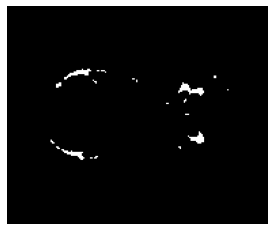

In [15]:
if modality_flag == 'rsfmri_0':
    plt.imshow(X[:,:,45], cmap='gray')
else:
    plt.imshow(X[:,:,80], cmap='gray')
plt.grid()
plt.axis('off')

In [16]:
from scipy import ndimage

(-0.5, 159.5, 191.5, -0.5)

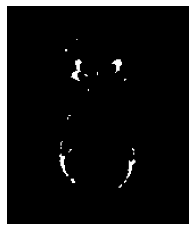

In [17]:
if modality_flag == 'rsfmri_0':
    plt.imshow(ndimage.rotate(X[:,:,45], 90), cmap='gray')
else:
    plt.imshow(ndimage.rotate(X[:,:,80], 90), cmap='gray')
plt.grid()
plt.axis('off')


plt.grid()
plt.axis('off')

In [18]:
if modality_flag == 'rsfmri_0':
    Upsample = torch.nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
    Xviz = Upsample(torch.unsqueeze(torch.unsqueeze(X, dim=0), dim=0)).numpy().copy()
else:
    Xviz = X.numpy().copy()
X = torch.unsqueeze(torch.unsqueeze(X, dim=0), dim=0)
X = X.type(torch.float)
X.shape

torch.Size([1, 1, 160, 192, 160])

In [19]:
model(X)

tensor([[77.7210]], grad_fn=<AddmmBackward0>)

# Let's try to get some attention

In [20]:
head_fusion='max'
discard_ratio = 0.9

def rollout(attentions, discard_ratio, head_fusion):
    # result = torch.eye(attentions[0].size(-1))
    
    results = []
    
    with torch.no_grad():
        for attention in attentions:
            results.append(attention)
            
            print(attention.shape)
            
#             if head_fusion == "mean":
#                 attention_heads_fused = attention.mean(axis=1)
#             elif head_fusion == "max":
#                 attention_heads_fused = attention.max(axis=1)[0]
#             elif head_fusion == "min":
#                 attention_heads_fused = attention.min(axis=1)[0]
#             else:
#                 raise "Attention head fusion type Not supported"

#             # Drop the lowest attentions, but
#             # don't drop the class token
#             flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
#             _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
#             indices = indices[indices != 0]
#             flat[0, indices] = 0

#             I = torch.eye(attention_heads_fused.size(-1))
#             a = (attention_heads_fused + 1.0*I)/2
#             a = a / a.sum(dim=-1)

#             result = torch.matmul(a, result)
    
#     # Look at the total attention between the class token,
#     # and the image patches
#     mask = result[0, 0 , 1 :]
#     # In case of 224x224 image, this brings us from 196 to 14
#     width = int(mask.size(-1)**0.5)
#     mask = mask.reshape(width, width).numpy()
#     mask = mask / np.max(mask)
#     return mask   

    return results

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='softmax', head_fusion="mean", ###########  softmax, attn_drop
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():

            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [21]:
print("Doing Attention Rollout")
attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
    discard_ratio=discard_ratio)
mask = attention_rollout(X)
# name = "attention_rollout_{:.3f}_{}.png".format(discard_ratio, head_fusion)

Doing Attention Rollout


None of the inputs have requires_grad=True. Gradients will be None


torch.Size([150, 3, 343, 343])
torch.Size([150, 3, 343, 343])
torch.Size([27, 6, 343, 343])
torch.Size([27, 6, 343, 343])
torch.Size([8, 12, 343, 343])
torch.Size([8, 12, 343, 343])
torch.Size([1, 24, 80, 80])
torch.Size([1, 24, 80, 80])


In [22]:
len(mask)

8

In [23]:
from SwinAgeMapper import window_reverse
from math import ceil, floor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from torch.nn import Upsample, ConstantPad3d

In [24]:
def GetAttentionActivation(mask, idx=0, patch=2):

    Din,Hin,Win = 160, 192, 160

    msk = mask[idx]
    mskQMean = msk.mean(axis=2) # mean across the querry axis
    mskQMean = mskQMean.permute(1,0,2)
    window_size = round(mskQMean.size(-1)**(1/3))

    if window_size == 7:
        window_size = (7,7,7)
    else:
        window_size = (window_size, int(mskQMean.size(-1) / window_size**2), window_size)

    print(mskQMean.shape, window_size)

    mskQMean = mskQMean.view(mskQMean.shape[0], mskQMean.shape[1],
                             window_size[0], window_size[1], window_size[2])

    n_windows_x = ceil(160/(7*patch))
    n_windows_y = ceil(192/(7*patch))
    n_windows_z = ceil(160/(7*patch))

    d, h, w = ceil(160/patch), ceil(192/patch), ceil(160/patch)

    print(d, h, w)

    if idx / 2 >= 1:
        idxPower = floor(idx / 2)
        n_windows_x = ceil(n_windows_x/2**idxPower)
        n_windows_y = ceil(n_windows_y/2**idxPower)
        n_windows_z = ceil(n_windows_z/2**idxPower)

        d, h, w = ceil(d / 2**idxPower), ceil(h / 2**idxPower), ceil(w / 2**idxPower)


    print('mskQMean', mskQMean.shape)

    if window_size == (7,7,7):
        out = window_reverse(mskQMean, (7,7,7), 
                             dims=(mskQMean.shape[0], n_windows_x*window_size[0], 
                                   n_windows_y*window_size[1], 
                                   n_windows_z*window_size[2])).squeeze()
    else:
        out = torch.squeeze(mskQMean)

    print('out_window_reverse', out.shape)


    if idx % 2 == 1:
        out = torch.roll(out, shifts=(3,3,3), dims=(1, 2, 3))

    print('out_rol', out.shape)

    out = out[:, :d, :h, :w].contiguous()

    print('out_crop', out.shape)

    if patch == 2:
        scale_factor = 2**(floor(idx / 2)+1)
    else:
        scale_factor = patch*2**(floor(idx / 2))
    upsample = Upsample(scale_factor=scale_factor)

    outUp = upsample(torch.unsqueeze(out, 1)).squeeze()

    print('outUp', outUp.shape)

    _, dOut,hOut, wOut = outUp.shape

    if Din != dOut or Hin != hOut or Win != wOut:
        outUp = outUp[:, :Din, :Hin, :Win].contiguous()

    print('outUp', outUp.shape)


    outUpCropMean = torch.mean(outUp, axis=0)
    outUpCropMax = torch.max(outUp, axis=0)[0]
    
    return outUp, outUpCropMean, outUpCropMax

def GetAllAttentionActivations(mask, patch=2, stop_early=False):
    
    outUpS, outUpCropMeanS, outUpCropMaxS = [], [], []
    
    if stop_early == True:
        idx_stop = len(mask)-2
    else:
        idx_stop = None
    
    for idx in range(len(mask)):
        if idx == idx_stop:
            break
        print('Processing Mask {}/{}'.format(idx, len(mask)-1))
        outUp, outUpCropMean, outUpCropMax = GetAttentionActivation(mask, idx=idx, patch=patch)
        outUpS.append(outUp)
        outUpCropMeanS.append(outUpCropMean)
        outUpCropMaxS.append(outUpCropMax)
        
    return outUpS, outUpCropMeanS, outUpCropMaxS

In [25]:
outUpS, outUpCropMeanS, outUpCropMaxS = GetAllAttentionActivations(mask, patch=5, stop_early=False)

Processing Mask 0/7
torch.Size([3, 150, 343]) (7, 7, 7)
32 39 32
mskQMean torch.Size([3, 150, 7, 7, 7])
out_window_reverse torch.Size([3, 35, 42, 35])
out_rol torch.Size([3, 35, 42, 35])
out_crop torch.Size([3, 32, 39, 32])
outUp torch.Size([3, 160, 195, 160])
outUp torch.Size([3, 160, 192, 160])
Processing Mask 1/7
torch.Size([3, 150, 343]) (7, 7, 7)
32 39 32
mskQMean torch.Size([3, 150, 7, 7, 7])
out_window_reverse torch.Size([3, 35, 42, 35])
out_rol torch.Size([3, 35, 42, 35])
out_crop torch.Size([3, 32, 39, 32])
outUp torch.Size([3, 160, 195, 160])
outUp torch.Size([3, 160, 192, 160])
Processing Mask 2/7
torch.Size([6, 27, 343]) (7, 7, 7)
32 39 32
mskQMean torch.Size([6, 27, 7, 7, 7])
out_window_reverse torch.Size([6, 21, 21, 21])
out_rol torch.Size([6, 21, 21, 21])
out_crop torch.Size([6, 16, 20, 16])
outUp torch.Size([6, 160, 200, 160])
outUp torch.Size([6, 160, 192, 160])
Processing Mask 3/7
torch.Size([6, 27, 343]) (7, 7, 7)
32 39 32
mskQMean torch.Size([6, 27, 7, 7, 7])
out_wi

In [26]:
def plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx, cmap='viridis',
    
                                  vmin=None, vmax=None):
    
    # CMAP ideas: viridis(default), inferno, bwr

    outUp = outUpS[idx]
    outUpCropMean = outUpCropMeanS[idx]
    outUpCropMax = outUpCropMaxS[idx]

    imgs = outUp.shape[0]
    # vmin = outUp.numpy().min()
    # vmax = outUp.numpy().max()
    fig, axs = plt.subplots(3, imgs, figsize=(imgs*5, 3*5))
    axs = axs.flatten()
    for i in range(imgs*3):
        if i < imgs:
            im = axs[i].imshow(ndimage.rotate(outUp[i,:,:,80], 90), cmap=cmap, vmin=vmin, vmax=vmax)
        elif i < 2*imgs:
            im = axs[i].imshow(ndimage.rotate(outUp[i-2*imgs,:,80,:], 90), cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            im = axs[i].imshow(ndimage.rotate(outUp[i-3*imgs,80,:,:], 90), cmap=cmap, vmin=vmin, vmax=vmax)

        axs[i].grid()
        axs[i].axis('off');

        fig.colorbar(im, ax=axs[i])

    fig.tight_layout()
    st = fig.suptitle("Plots Across Multi-Heads", fontsize="xx-large")
    fig.subplots_adjust(top=0.95)



    fig, axs = plt.subplots(2,3, figsize=(15, 10))
    axs = axs.flatten()
    im = axs[0].imshow(ndimage.rotate(outUpCropMean[:,:,80], 90), cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0].grid()
    axs[0].axis('off');
    fig.colorbar(im, ax=axs[0])
    im = axs[1].imshow(ndimage.rotate(outUpCropMean[:,80,:], 90), cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].grid()
    axs[1].axis('off');
    fig.colorbar(im, ax=axs[1])
    im = axs[2].imshow(ndimage.rotate(outUpCropMean[80,:,:], 90), cmap=cmap, vmin=vmin, vmax=vmax)
    axs[2].grid()
    axs[2].axis('off');
    fig.colorbar(im, ax=axs[2])
    im = axs[3].imshow(ndimage.rotate(outUpCropMax[:,:,80], 90), cmap=cmap, vmin=vmin, vmax=vmax)
    axs[3].grid()
    axs[3].axis('off');
    fig.colorbar(im, ax=axs[3])
    im = axs[4].imshow(ndimage.rotate(outUpCropMax[:,80,:], 90), cmap=cmap, vmin=vmin, vmax=vmax)
    axs[4].grid()
    axs[4].axis('off');
    fig.colorbar(im, ax=axs[4])
    im = axs[5].imshow(ndimage.rotate(outUpCropMax[80,:,:], 90), cmap=cmap, vmin=vmin, vmax=vmax)
    axs[5].grid()
    axs[5].axis('off');
    fig.colorbar(im, ax=axs[5])
    fig.tight_layout()

    st = fig.suptitle("Mean and Max Across Multi-Heads", fontsize="xx-large")
    fig.subplots_adjust(top=0.95)

In [27]:
outUpS_npy, outUpCropMeanS_npy, outUpCropMaxS_npy = [], [], []

for file in outUpS:
    file = file.numpy()
    outUpS_npy.append(file)
    
for file in outUpCropMeanS:
    file = file.numpy()
    outUpCropMeanS_npy.append(file)
    
for file in outUpCropMaxS:
    file = file.numpy()
    outUpCropMaxS_npy.append(file)

In [28]:
type(outUpS_npy[0])

numpy.ndarray

In [29]:
# np.save('outUpS.npy',         np.array(outUpS_npy,         dtype=object), allow_pickle=True)
# np.save('outUpCropMeanS.npy', np.array(outUpCropMeanS_npy, dtype=object), allow_pickle=True)
# np.save('outUpCropMaxS.npy',  np.array(outUpCropMaxS_npy,  dtype=object), allow_pickle=True)

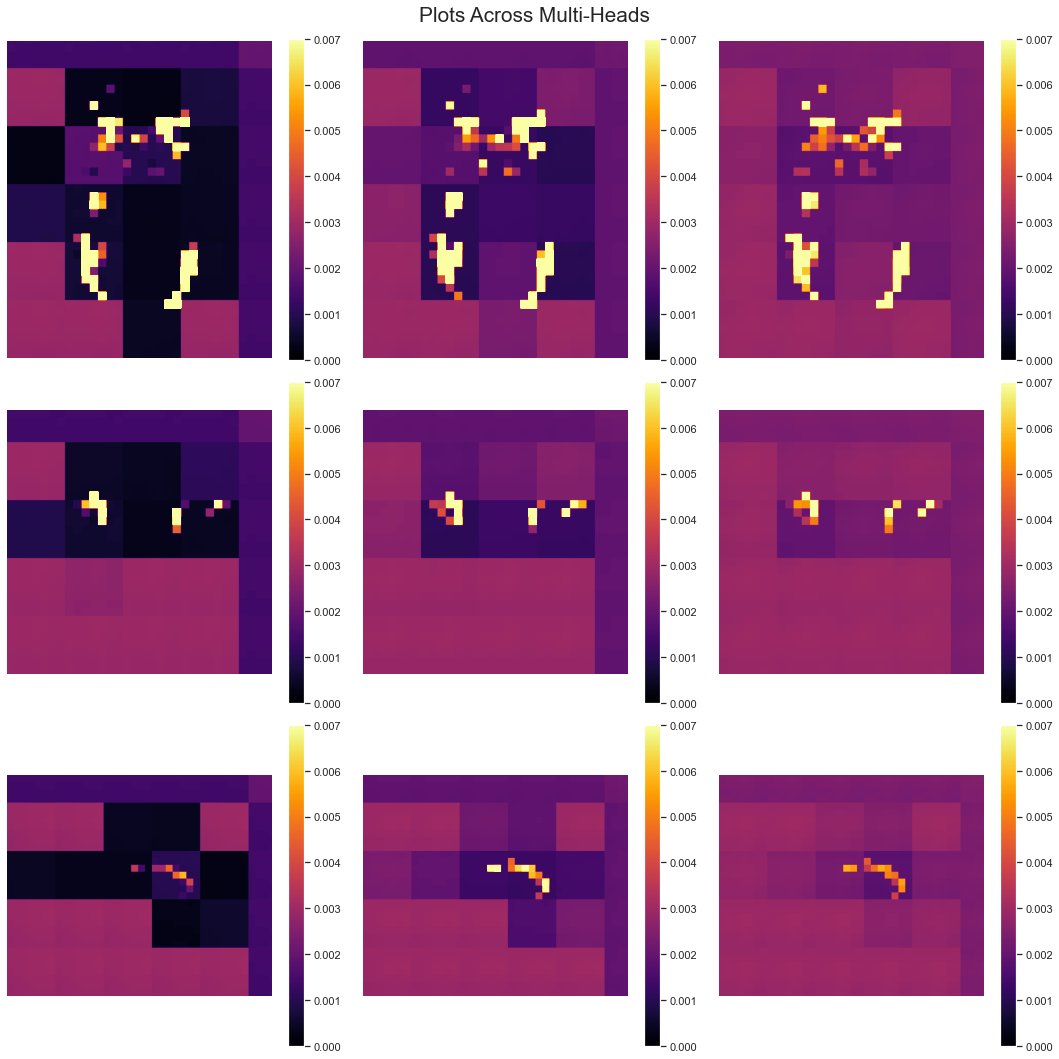

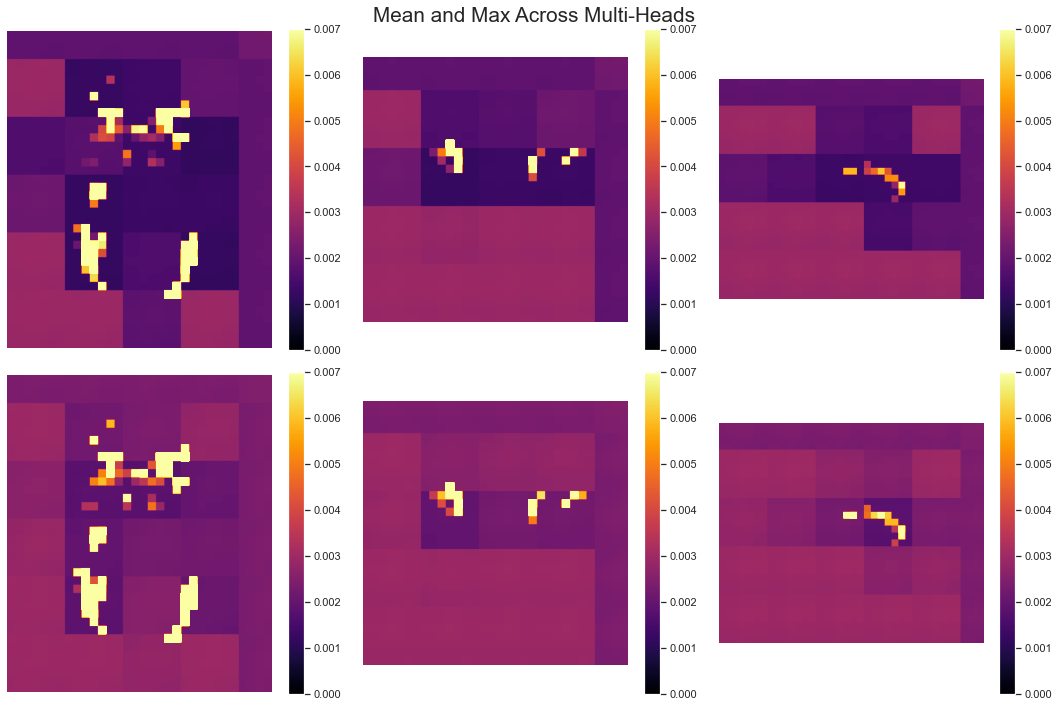

In [30]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=0, cmap='inferno',
                              vmin=0, vmax=0.007
                              )

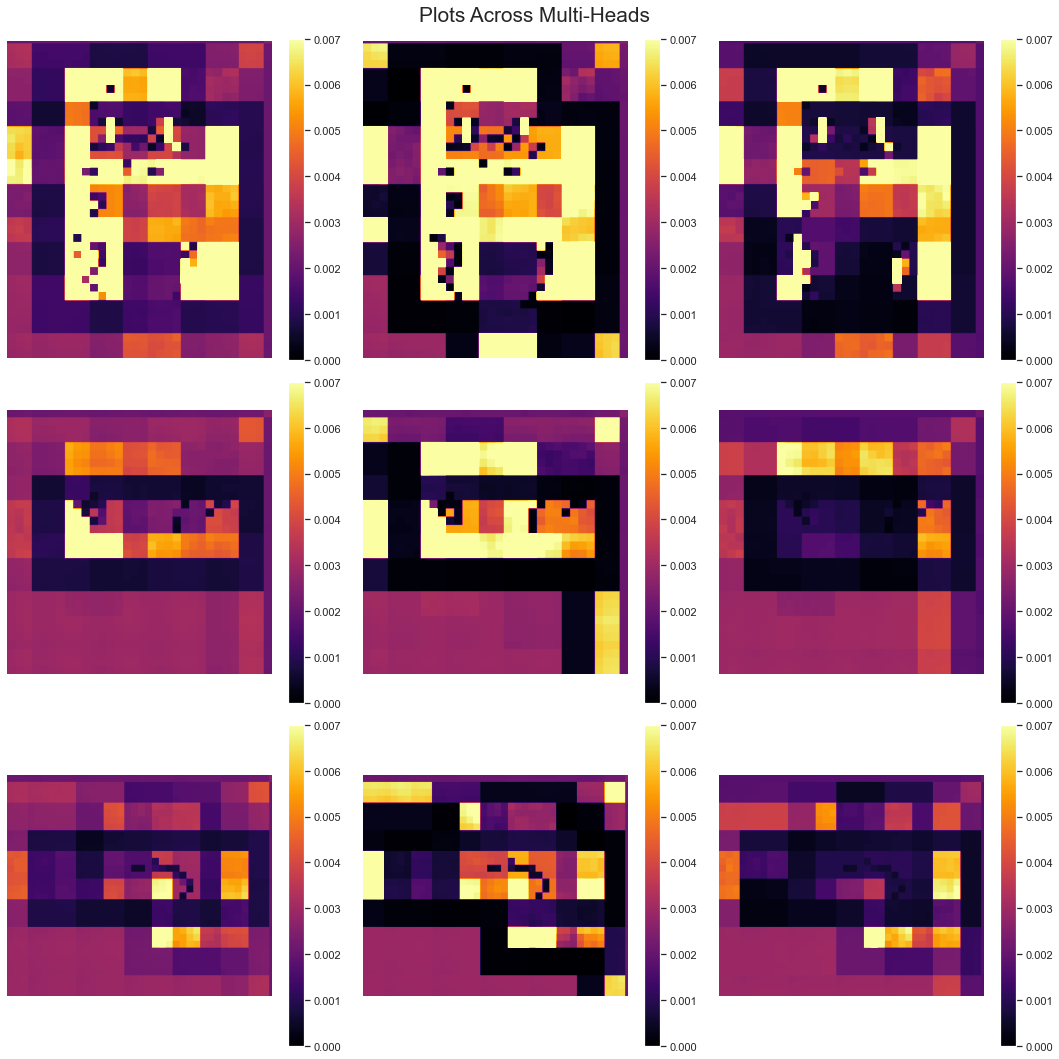

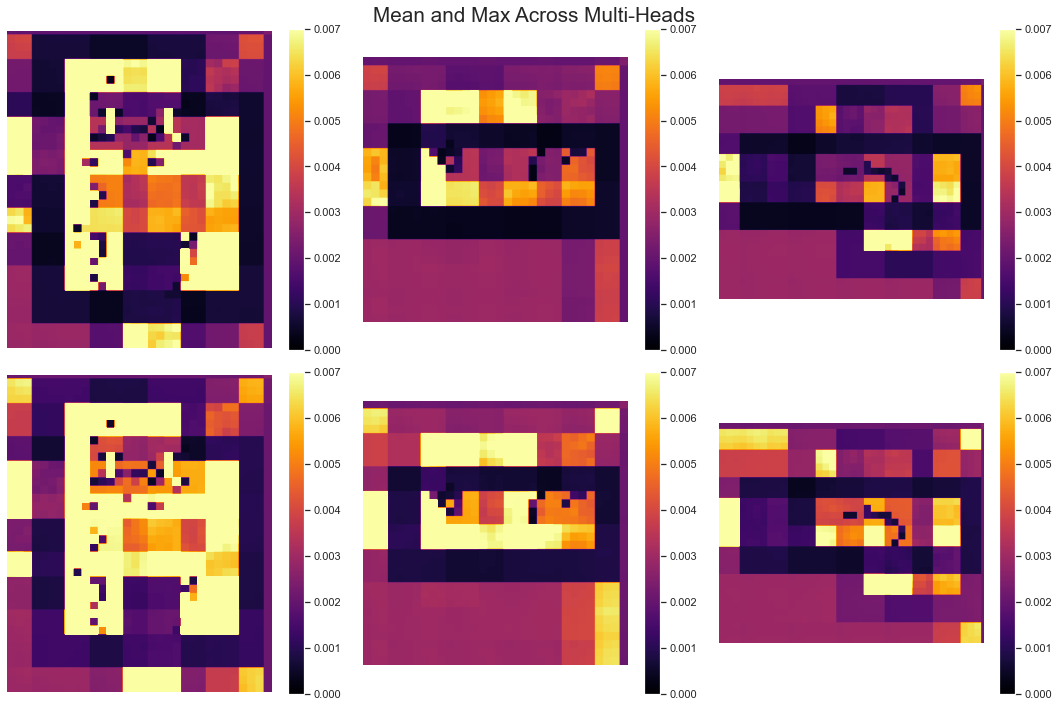

In [31]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=1, cmap='inferno',
                              vmin=0, vmax=0.007
                              )

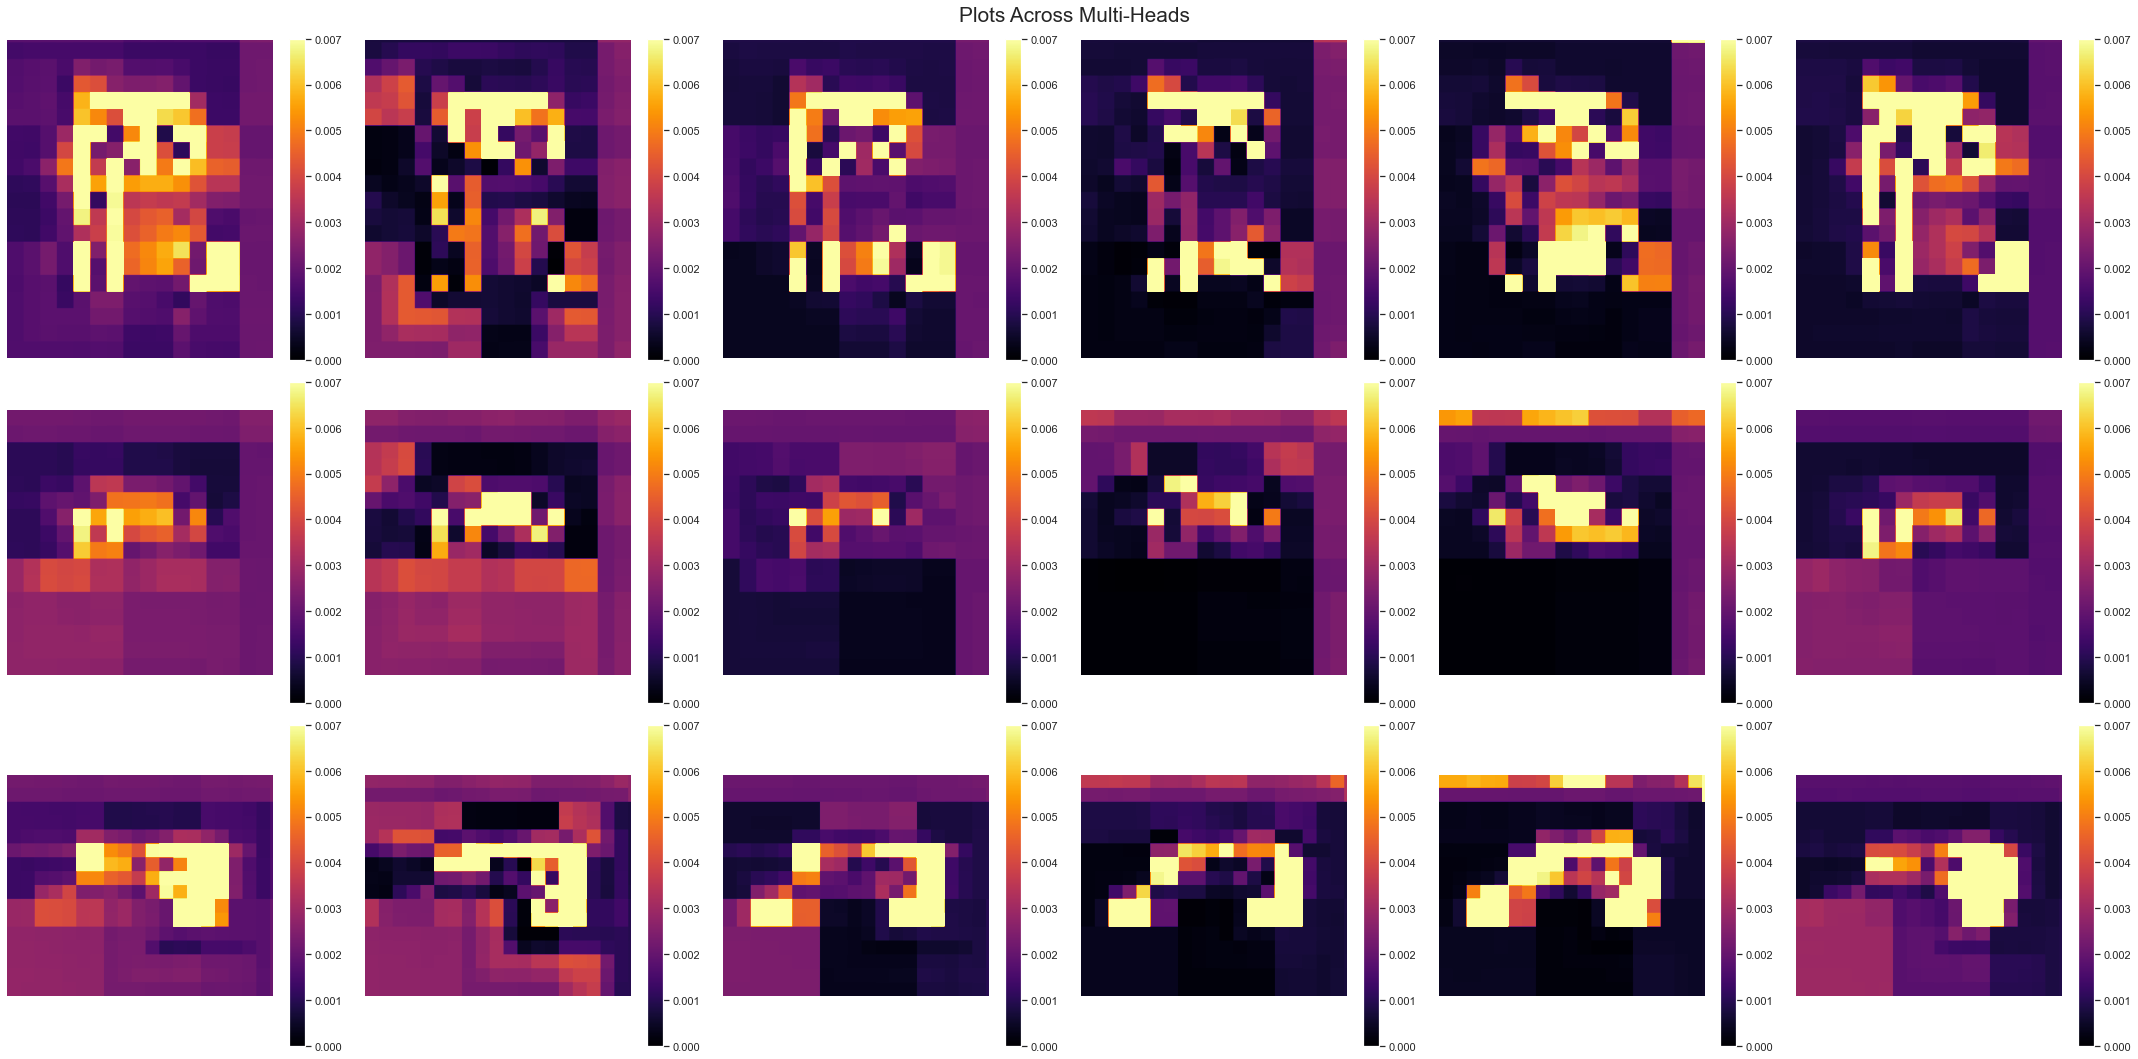

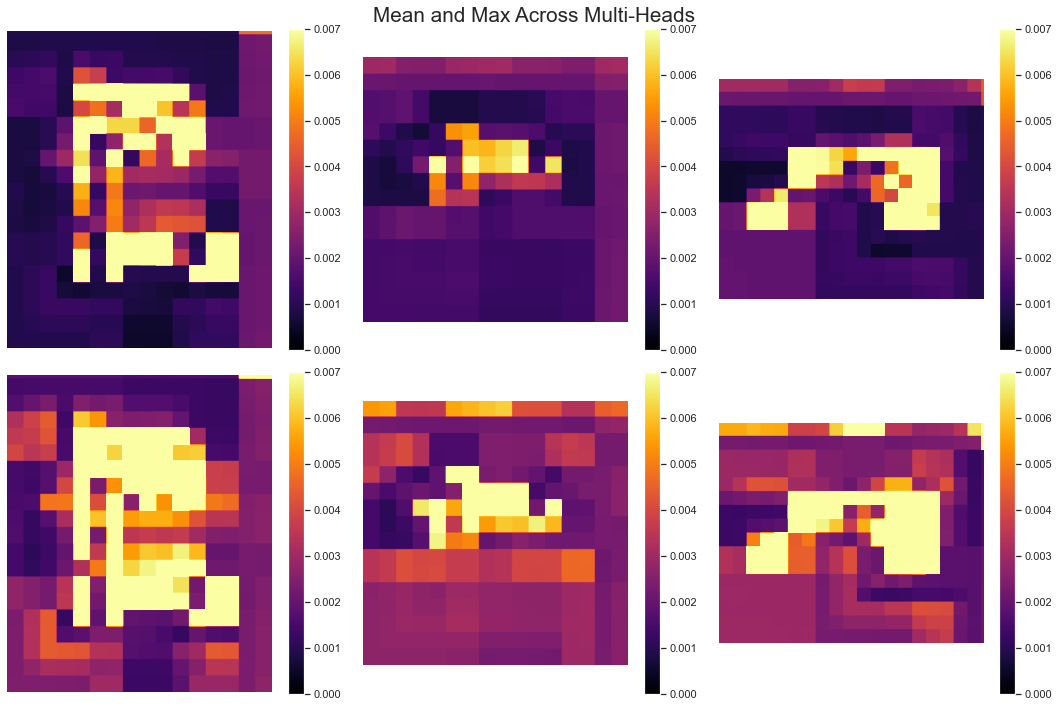

In [32]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=2, cmap='inferno',
                              vmin=0, vmax=0.007
                              )

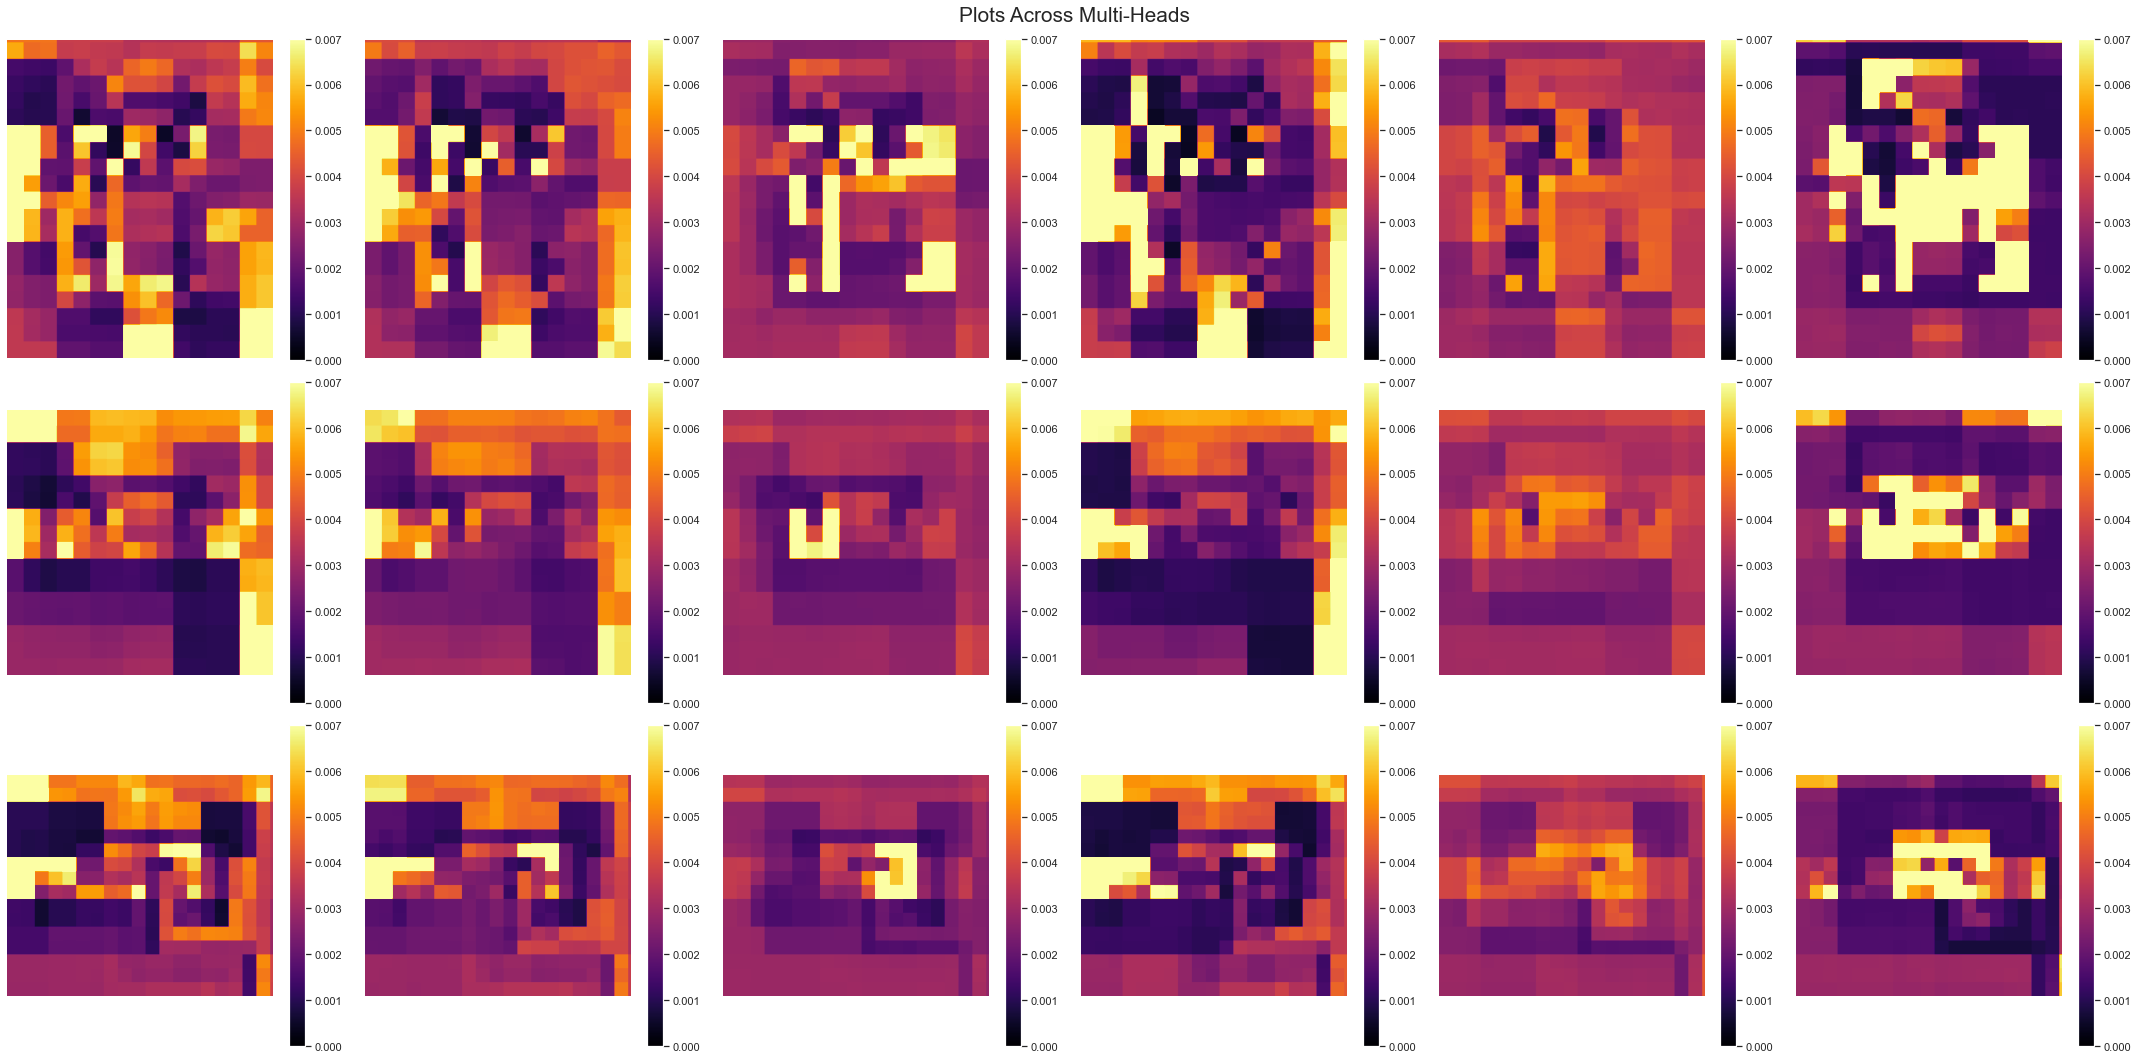

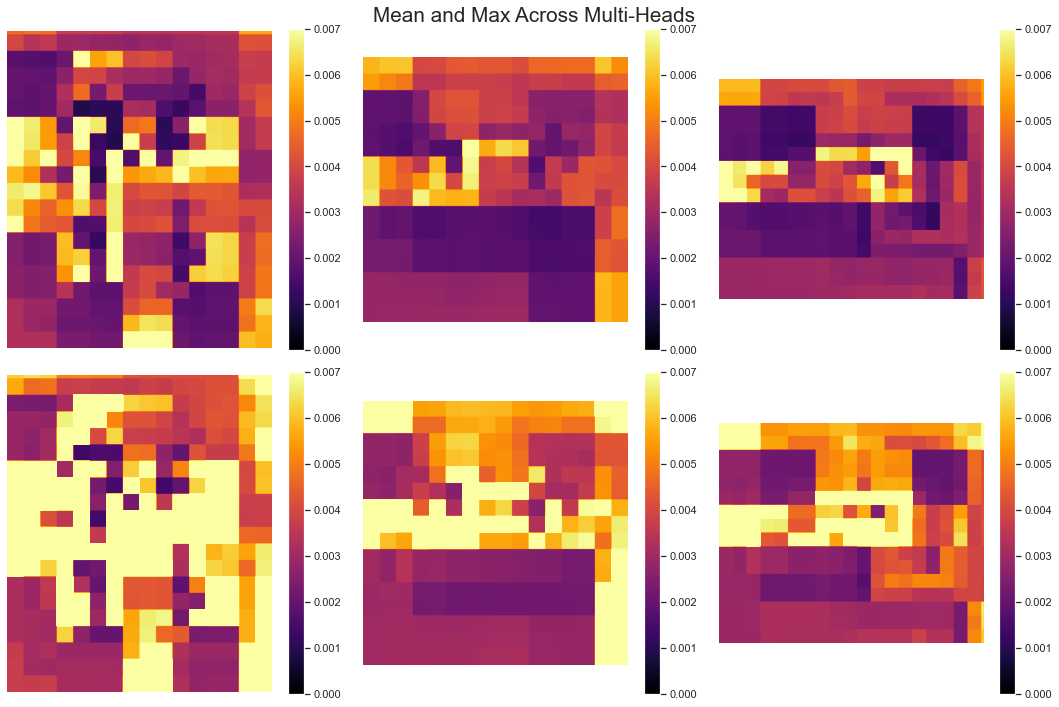

In [33]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=3, cmap='inferno',
                              vmin=0, vmax=0.007
                              )

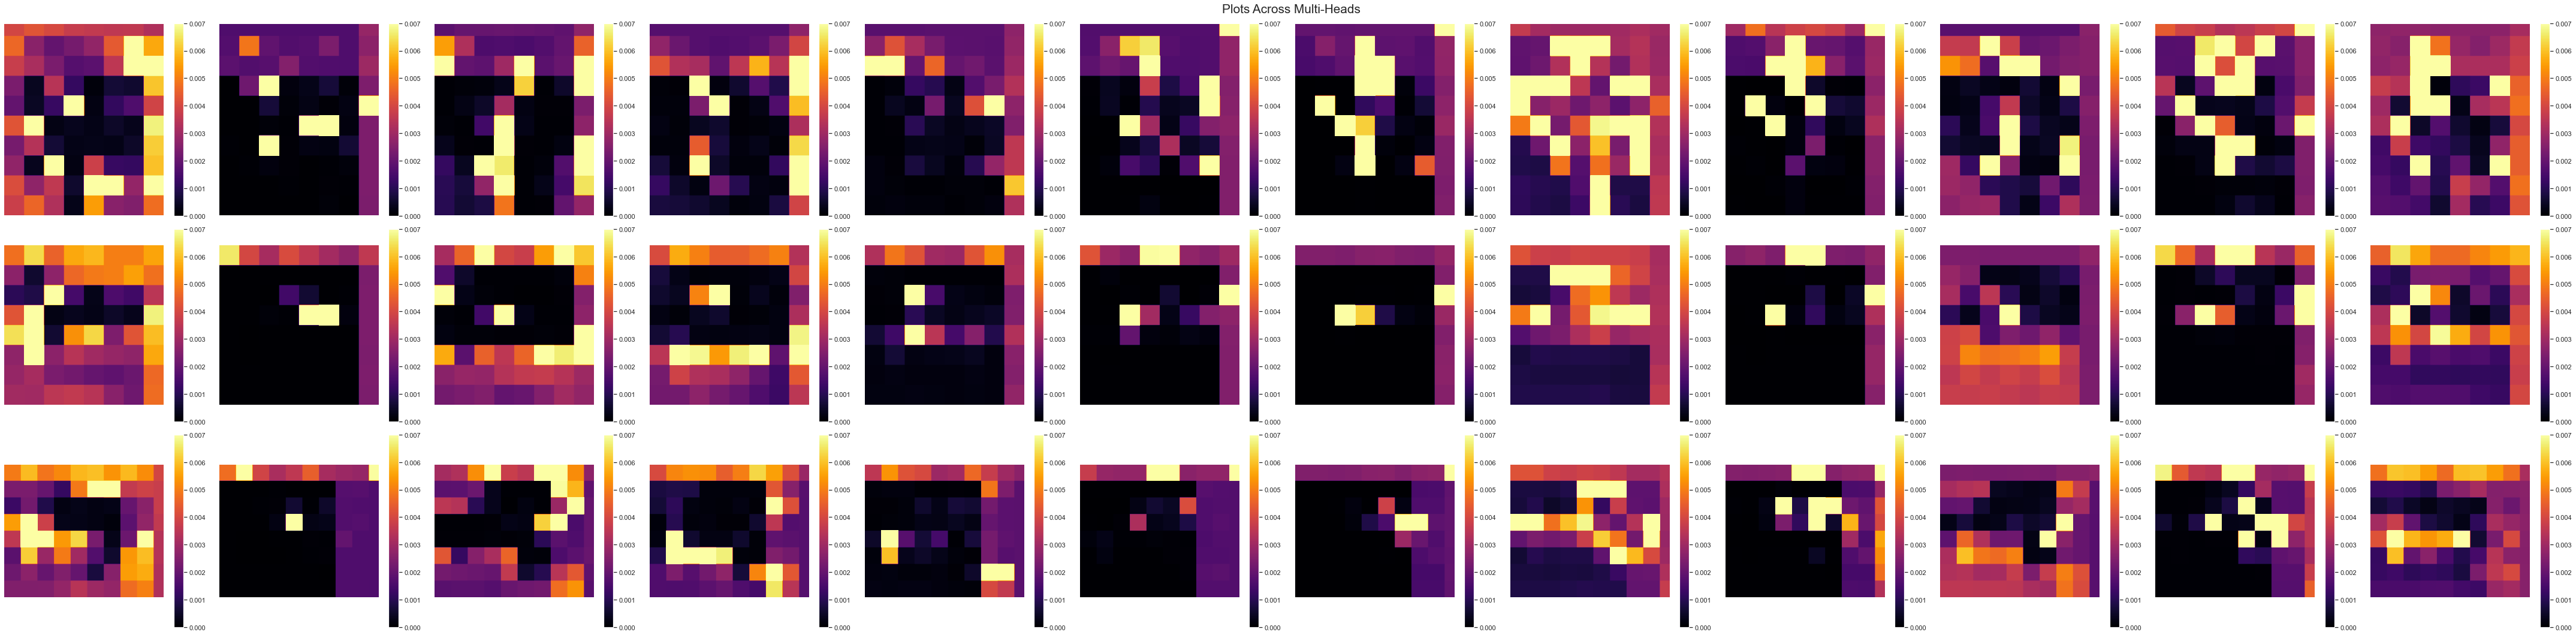

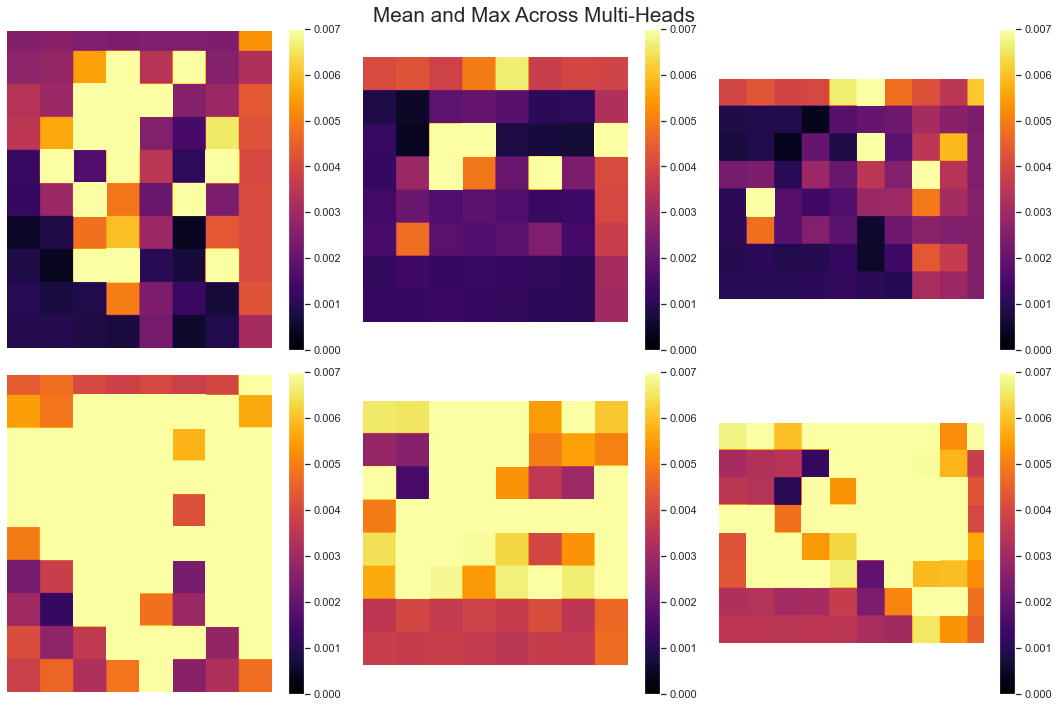

In [34]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=4, cmap='inferno',
                              vmin=0, vmax=0.007
                              )

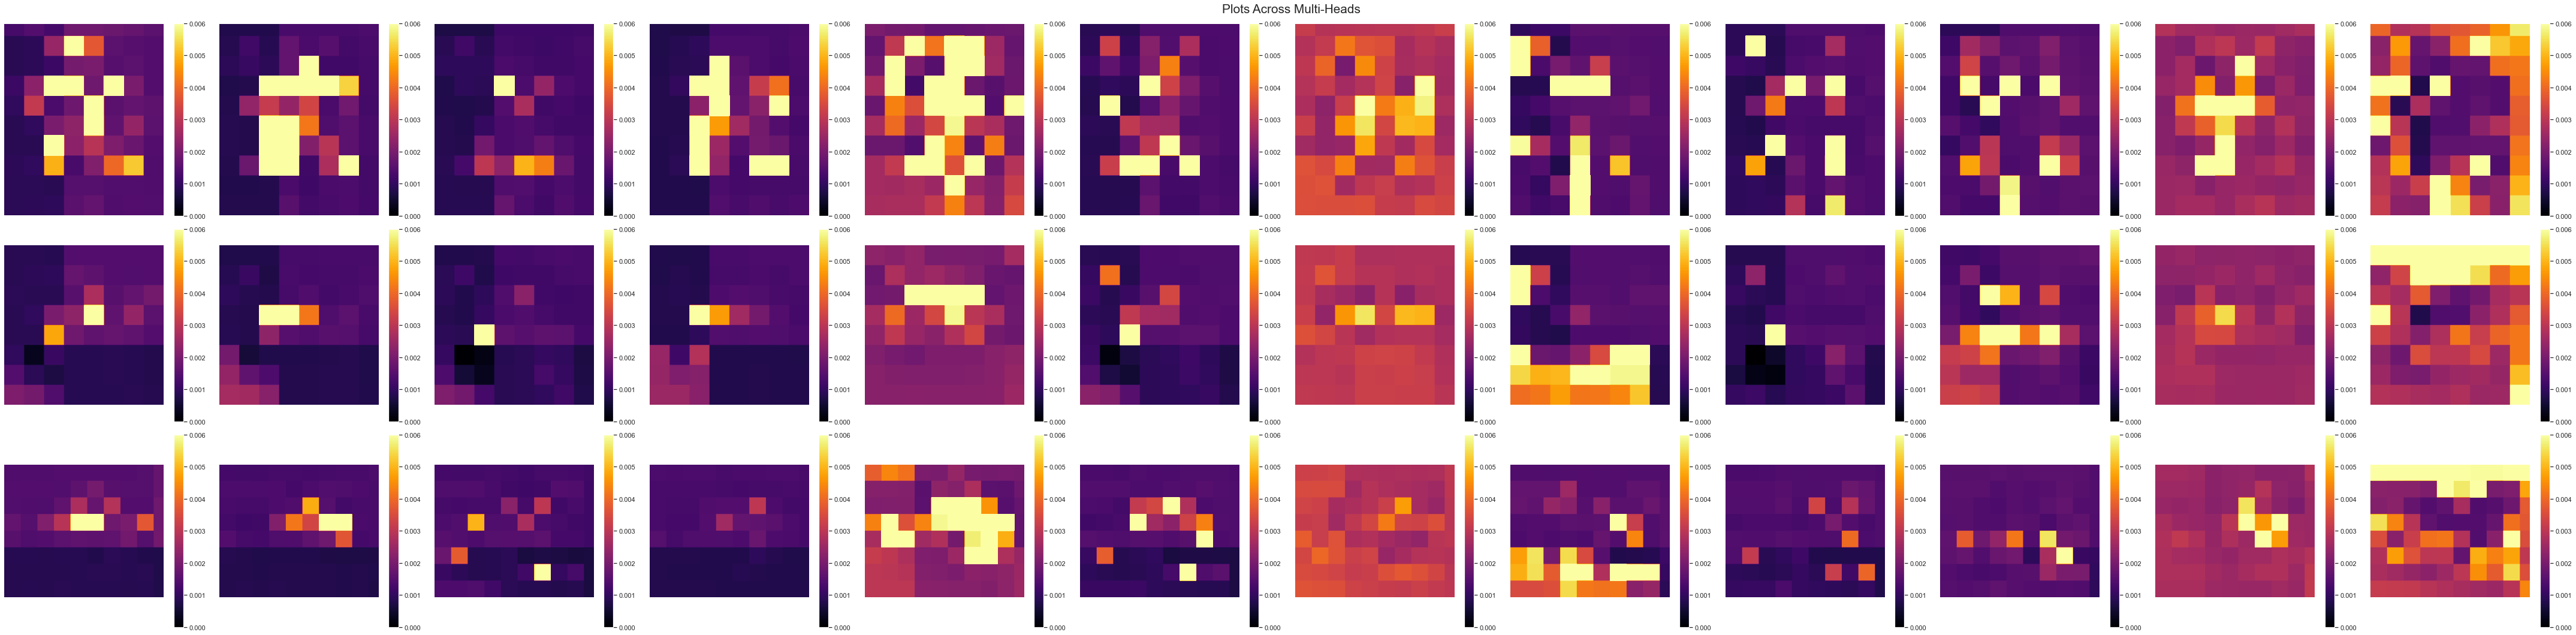

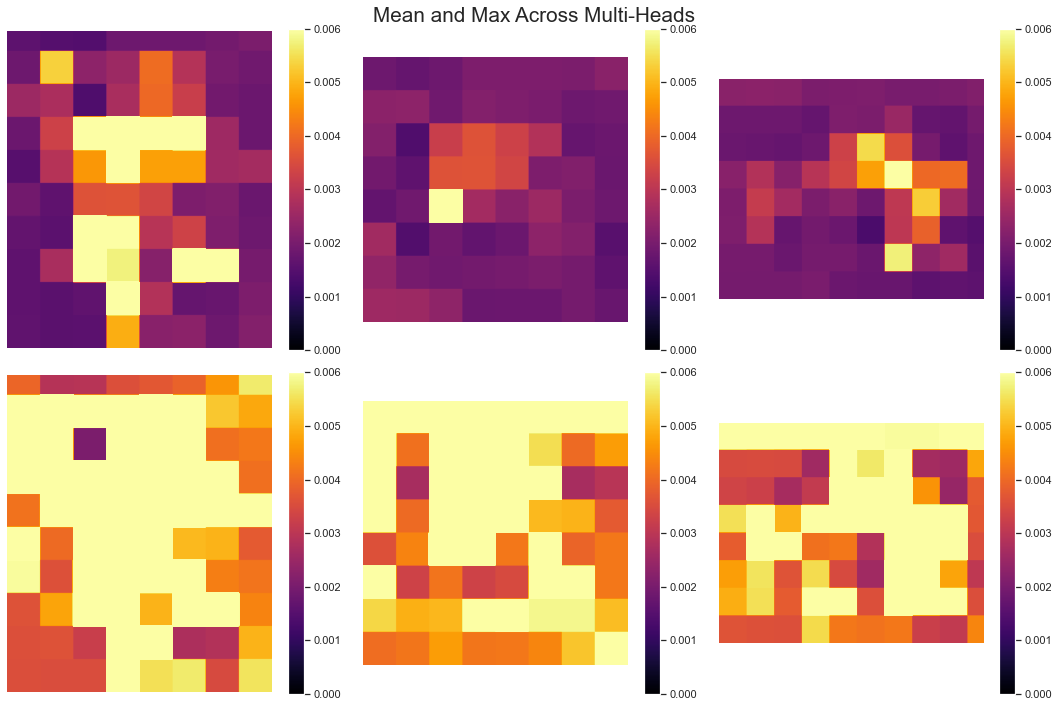

In [35]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=5, cmap='inferno',
                              vmin=0, vmax=0.006
                              )

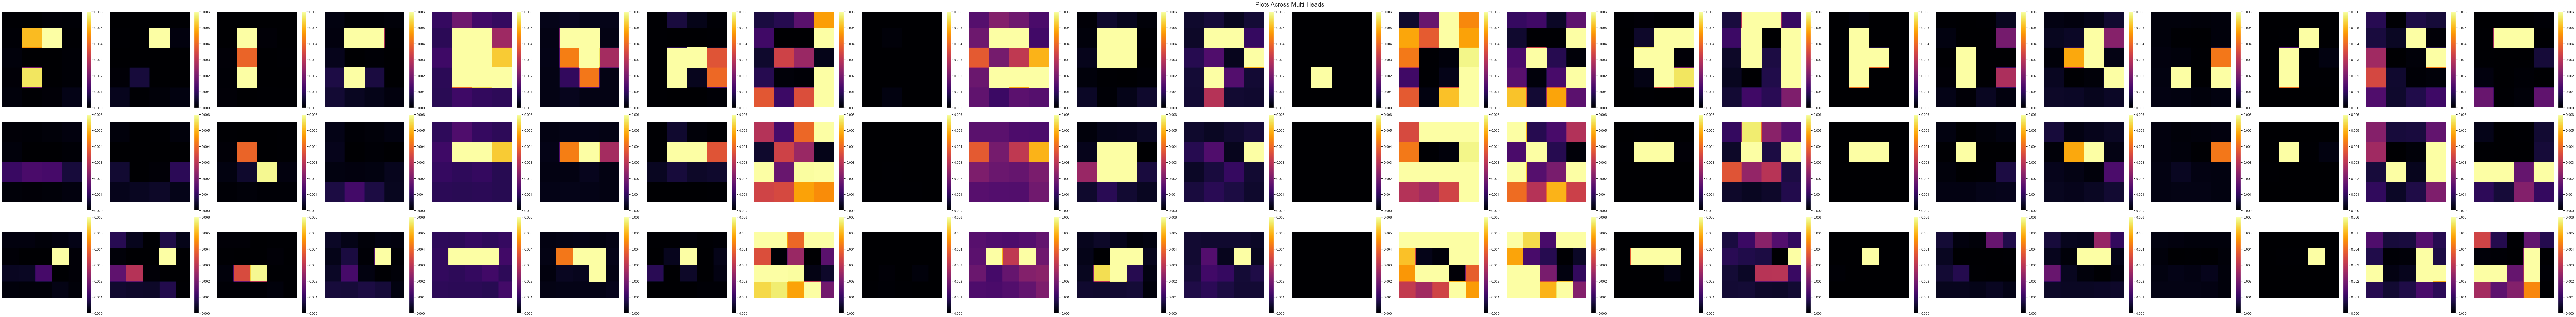

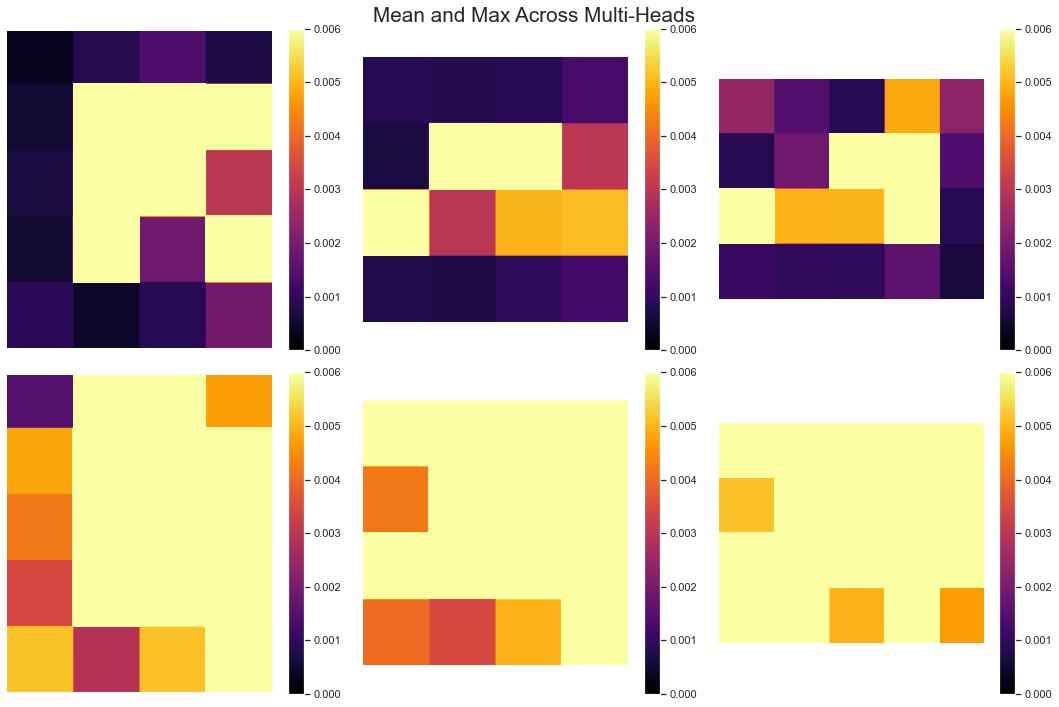

In [36]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=6, cmap='inferno',
                              vmin=0, vmax=0.006
                              )

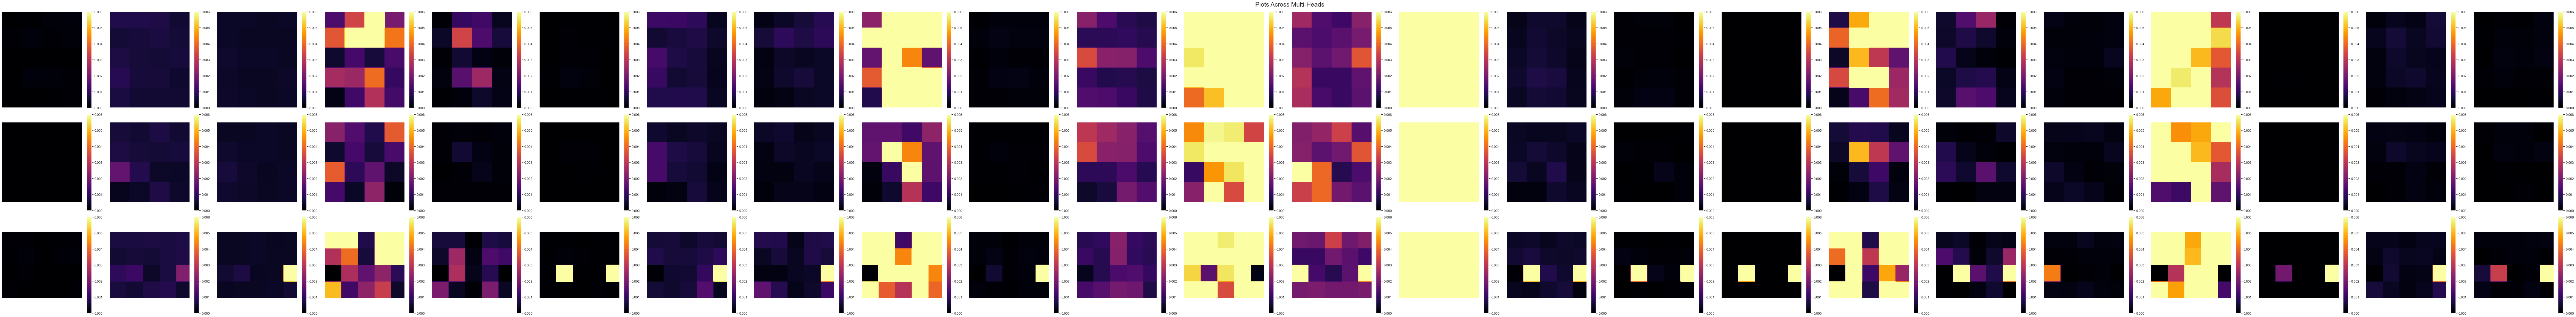

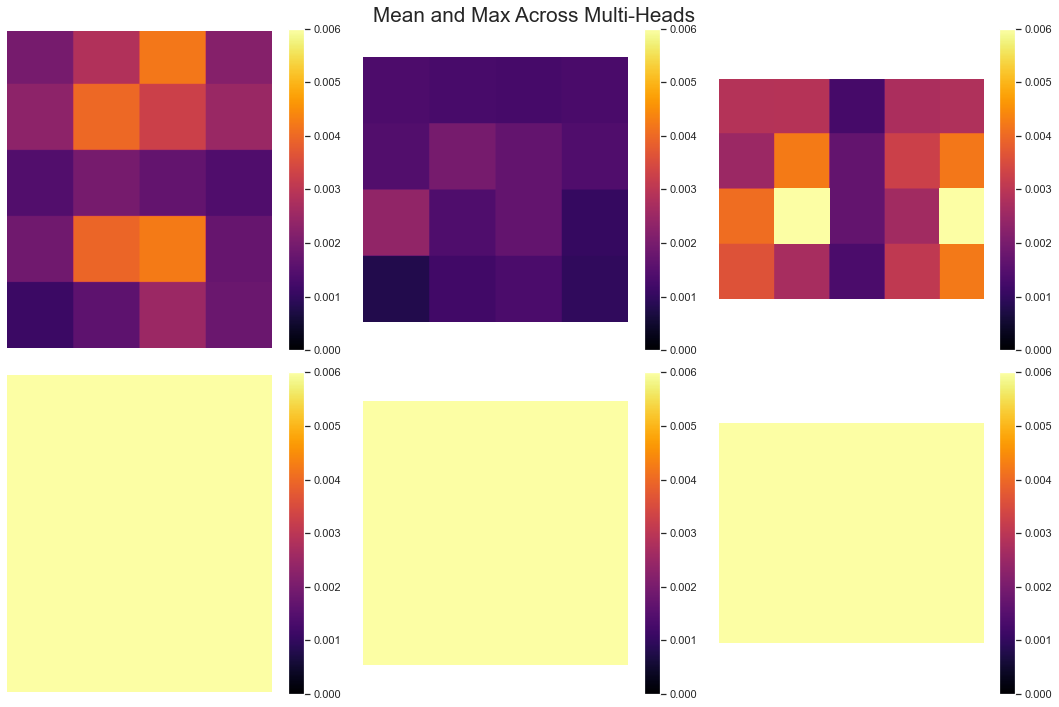

In [37]:
plotAttentionHeadAttentionMaps(outUpS, outUpCropMeanS, outUpCropMaxS, idx=7, cmap='inferno',
                              vmin=0, vmax=0.006
                              )

In [38]:
for idx in range(len(outUpCropMeanS)):
    print(outUpCropMeanS[idx].shape)

torch.Size([160, 192, 160])
torch.Size([160, 192, 160])
torch.Size([160, 192, 160])
torch.Size([160, 192, 160])
torch.Size([160, 192, 160])
torch.Size([160, 192, 160])
torch.Size([160, 192, 160])
torch.Size([160, 192, 160])


# Let's look at some Attention Rollout

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import ndimage

In [40]:
# outUpS = np.load('outUpS.npy', allow_pickle=True)
outUpS = np.array(outUpS_npy,         dtype=object)
outUpCropMeanS = np.array(outUpCropMeanS_npy,         dtype=object)
outUpCropMaxS = np.array(outUpCropMaxS_npy,         dtype=object)

In [41]:
def plotAttentionHead_Overlay(outUpS, idx=None, cmap='viridis', vmin=None, vmax=None, minMax=False, 
                             title=None):
    
    # CMAP ideas: viridis(default), inferno, bwr
    
    if minMax == False:
        
        if len(outUpS.shape) == 1:
            outUp = outUpS[idx]
        else:
            outUp = outUpS

        imgs = outUp.shape[0]

        fig, axs = plt.subplots(3, imgs, figsize=(imgs*5, 3*5))
        axs = axs.flatten()
        
        for i in range(imgs*3):
            if i < imgs:
                im = axs[i].imshow(ndimage.rotate(Xviz[:,:,80], 90), cmap='gray')
                im = axs[i].imshow(ndimage.rotate(outUp[i,:,:,80], 90), cmap=cmap, alpha=0.75, vmin=vmin, vmax=vmax)
            elif i < 2*imgs:
                im = axs[i].imshow(ndimage.rotate(Xviz[:,80,:], 90), cmap='gray')
                im = axs[i].imshow(ndimage.rotate(outUp[i-2*imgs,:,80,:], 90), cmap=cmap, alpha=0.75, vmin=vmin, vmax=vmax)
            else:
                im = axs[i].imshow(ndimage.rotate(Xviz[80,:,:], 90), cmap='gray')
                im = axs[i].imshow(ndimage.rotate(outUp[i-3*imgs,80,:,:], 90), cmap=cmap, alpha=0.75, vmin=vmin, vmax=vmax)

            axs[i].grid()
            axs[i].axis('off');

            fig.colorbar(im, ax=axs[i])
    else:
        
        outUp = outUpS[idx, :, :, :]
        
        fig, axs = plt.subplots(1,3, figsize=(15, 5))
        axs = axs.flatten()

        im = axs[0].imshow(ndimage.rotate(Xviz[:,:,80], 90), cmap='gray')
        im = axs[0].imshow(ndimage.rotate(outUp.astype('float32')[:,:,80], 90), cmap=cmap, alpha=0.75, vmin=vmin, vmax=vmax)        
        axs[0].grid()
        axs[0].axis('off');
        fig.colorbar(im, ax=axs[0])
        
        im = axs[1].imshow(ndimage.rotate(Xviz[:,80,:], 90), cmap='gray')
        im = axs[1].imshow(ndimage.rotate(outUp.astype('float32')[:,80,:], 90), cmap=cmap, alpha=0.75, vmin=vmin, vmax=vmax)
        axs[1].grid()
        axs[1].axis('off');
        fig.colorbar(im, ax=axs[1])
        
        im = axs[2].imshow(ndimage.rotate(Xviz[80,:,:], 90), cmap='gray')
        im = axs[2].imshow(ndimage.rotate(outUp.astype('float32')[80,:,:], 90), cmap=cmap, alpha=0.75, vmin=vmin, vmax=vmax)
        axs[2].grid()
        axs[2].axis('off');
        fig.colorbar(im, ax=axs[2])
        
    fig.tight_layout()
    if title == None:
        pltTitle = "Avg OR Max plot at level " + str(idx+1)
    else:
        pltTitle = title +  " at Depth Level " + str(idx+1) + " in the Network"
        
    st = fig.suptitle(pltTitle, fontsize="xx-large")
    fig.subplots_adjust(top=0.95)

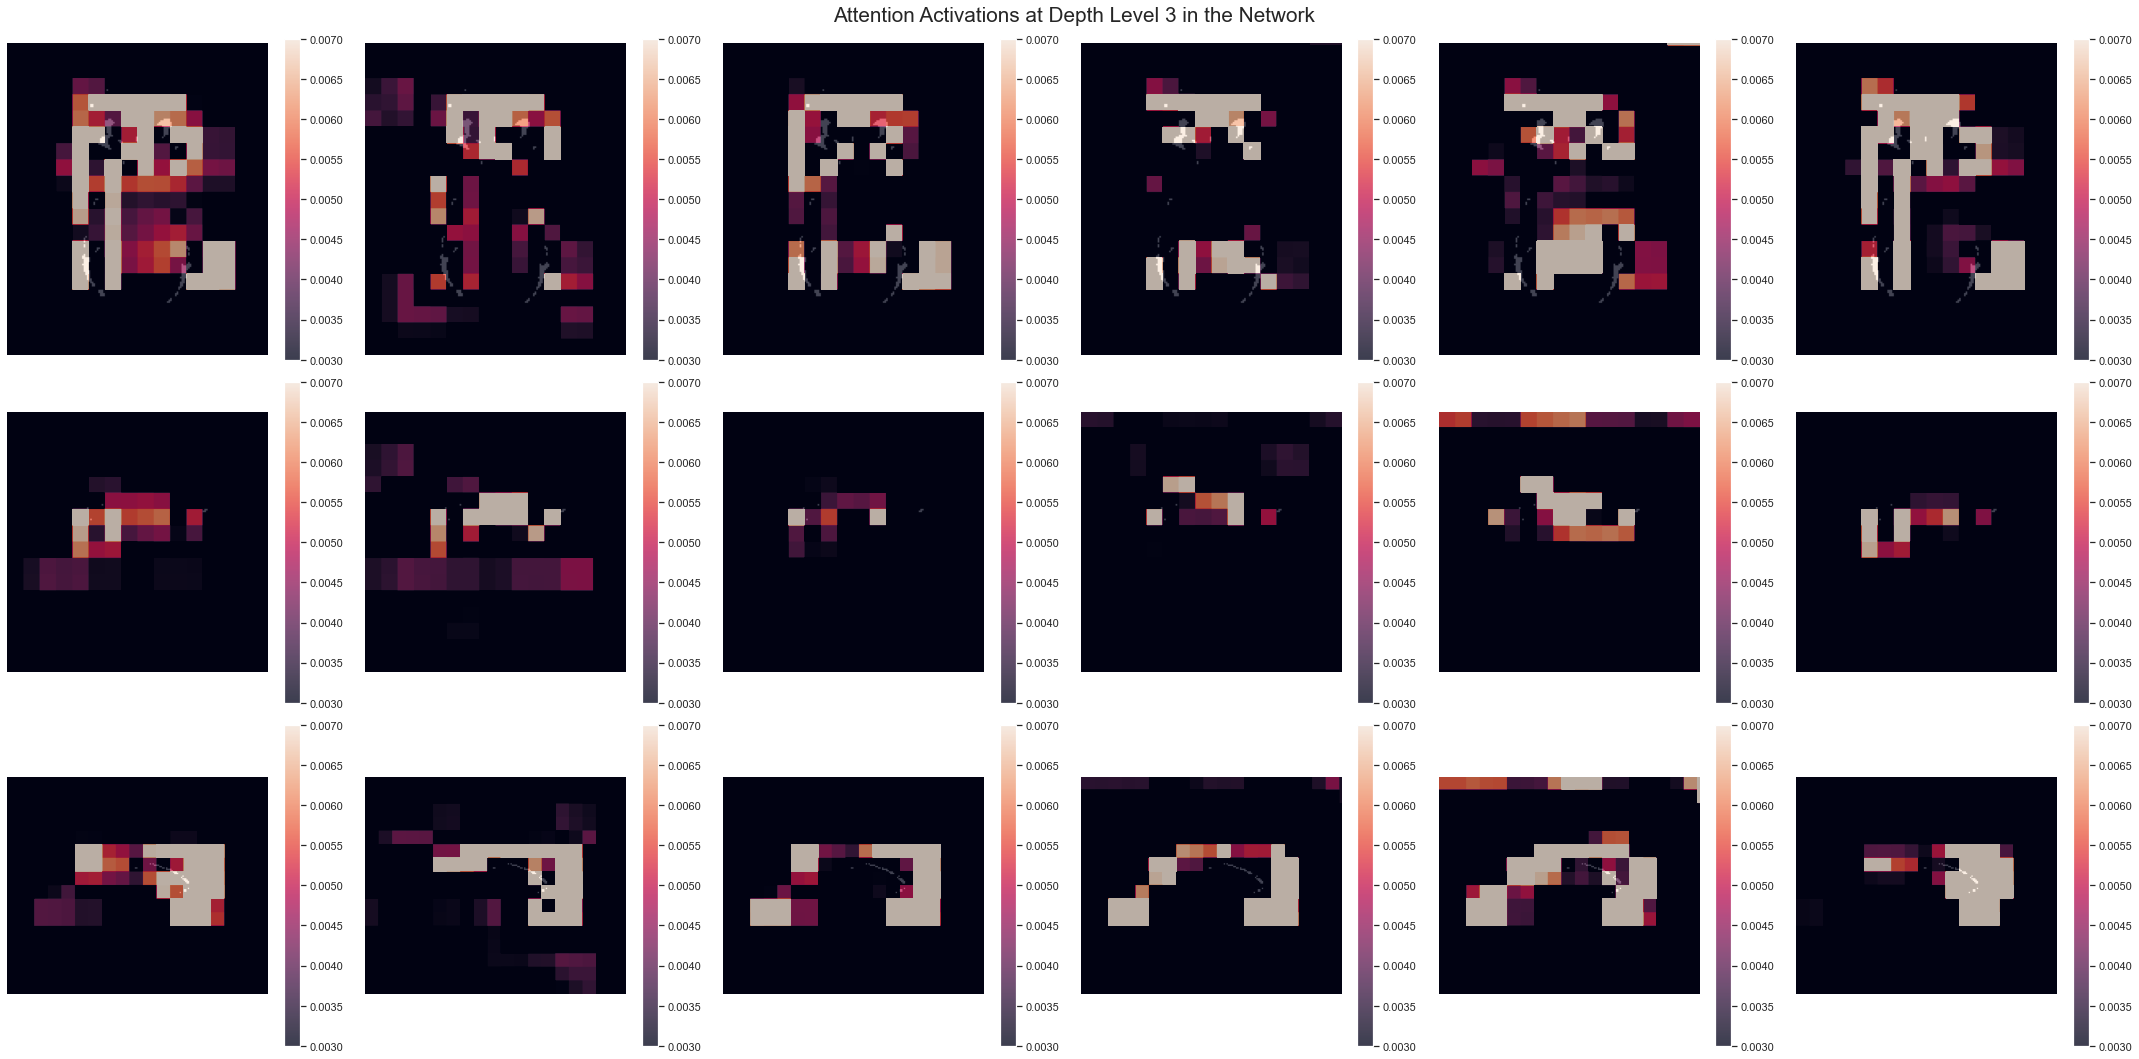

In [42]:
plotAttentionHead_Overlay(outUpS, 2, cmap=None, vmin=0.003, vmax=0.007, title='Attention Activations')

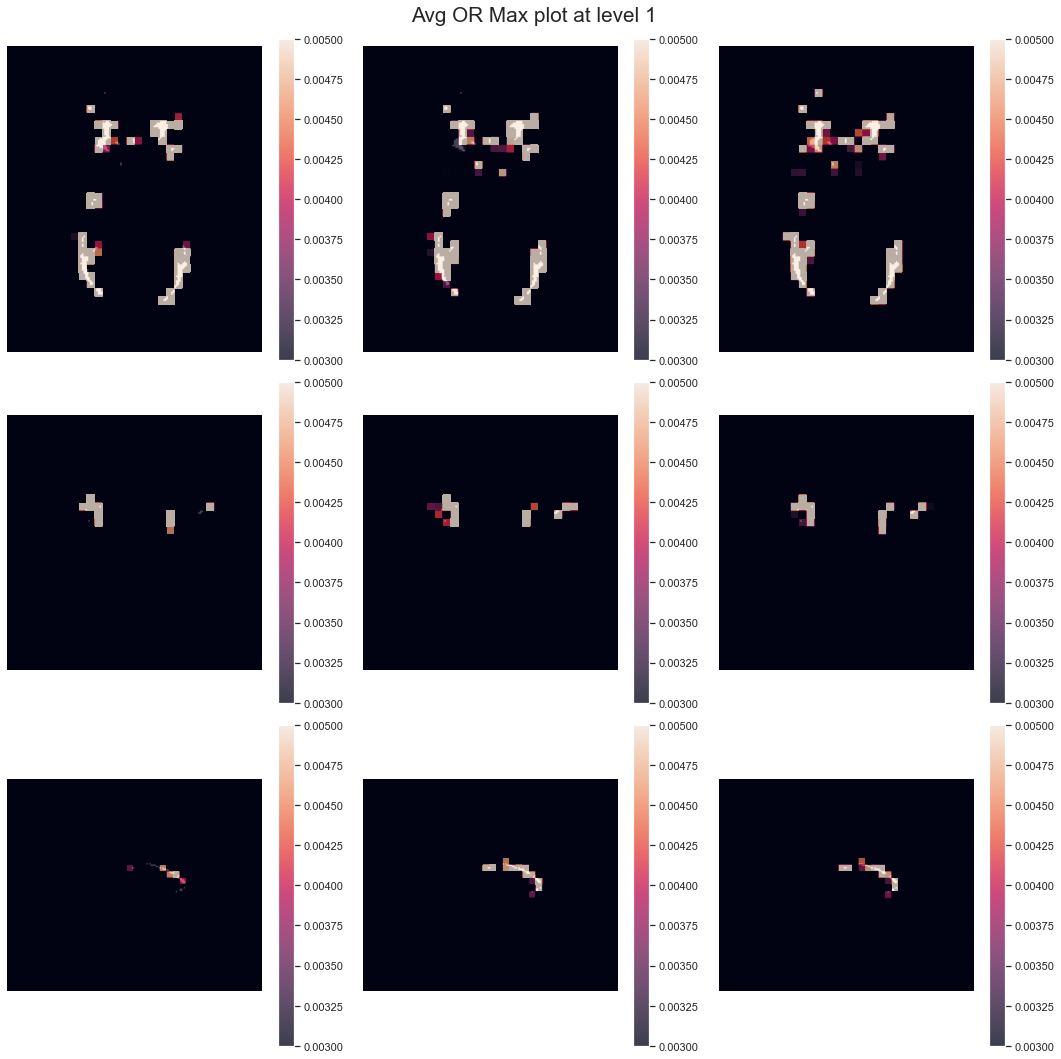

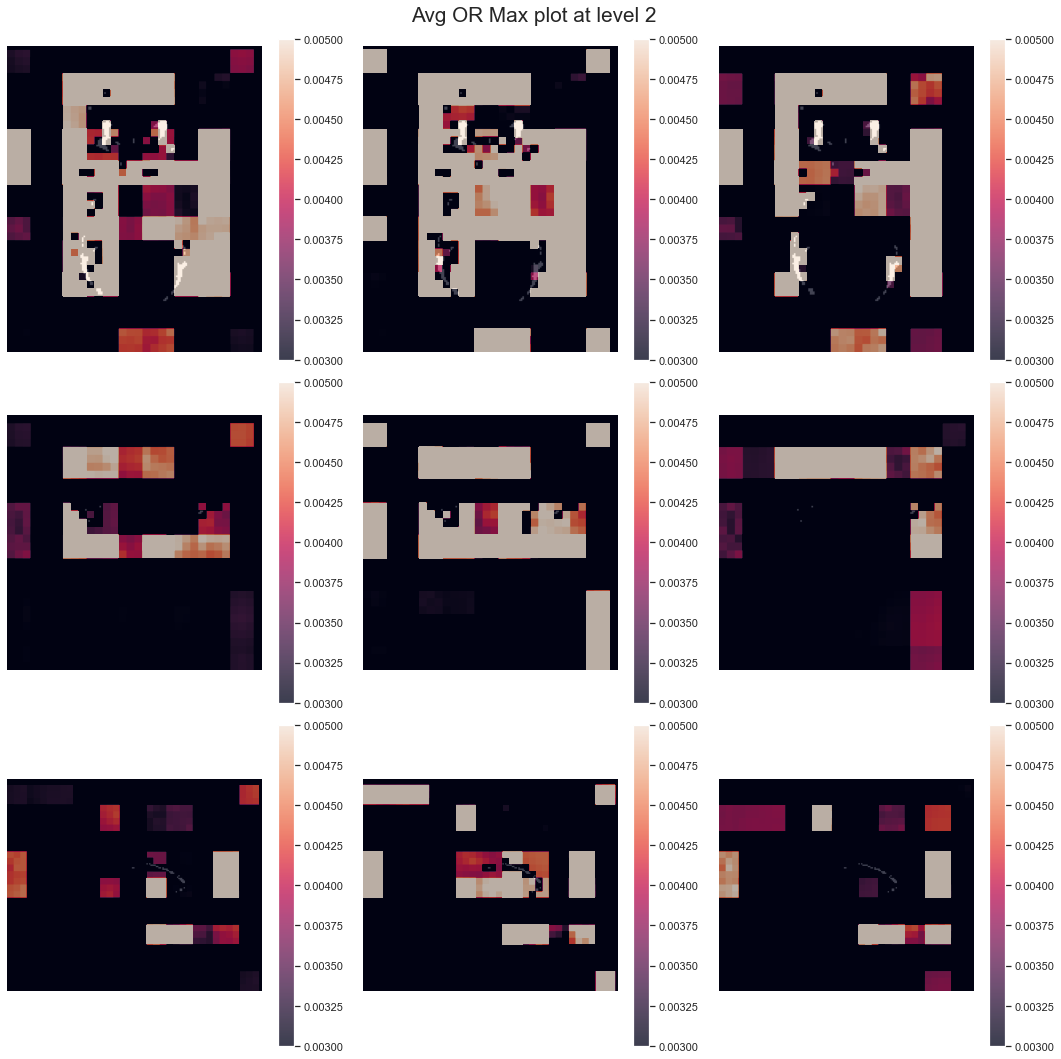

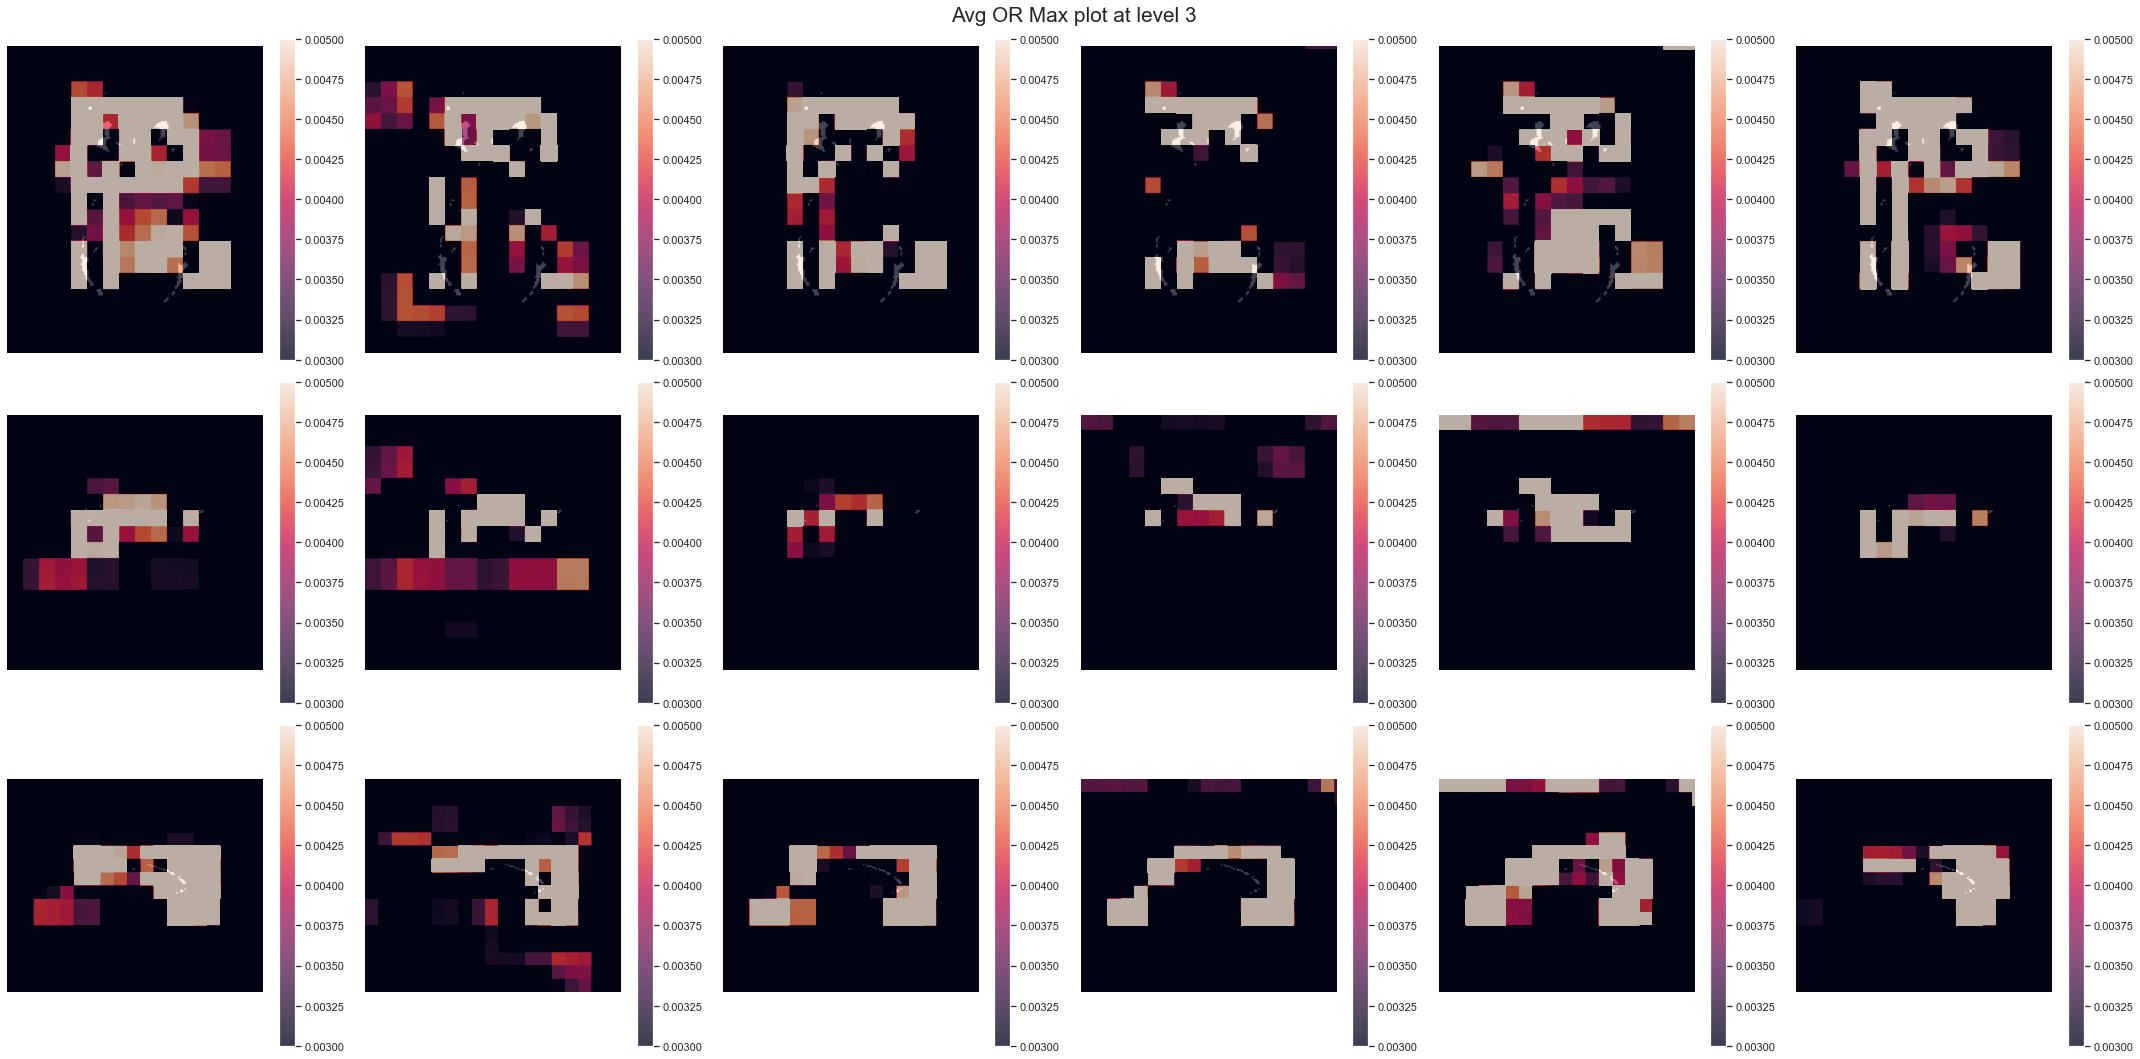

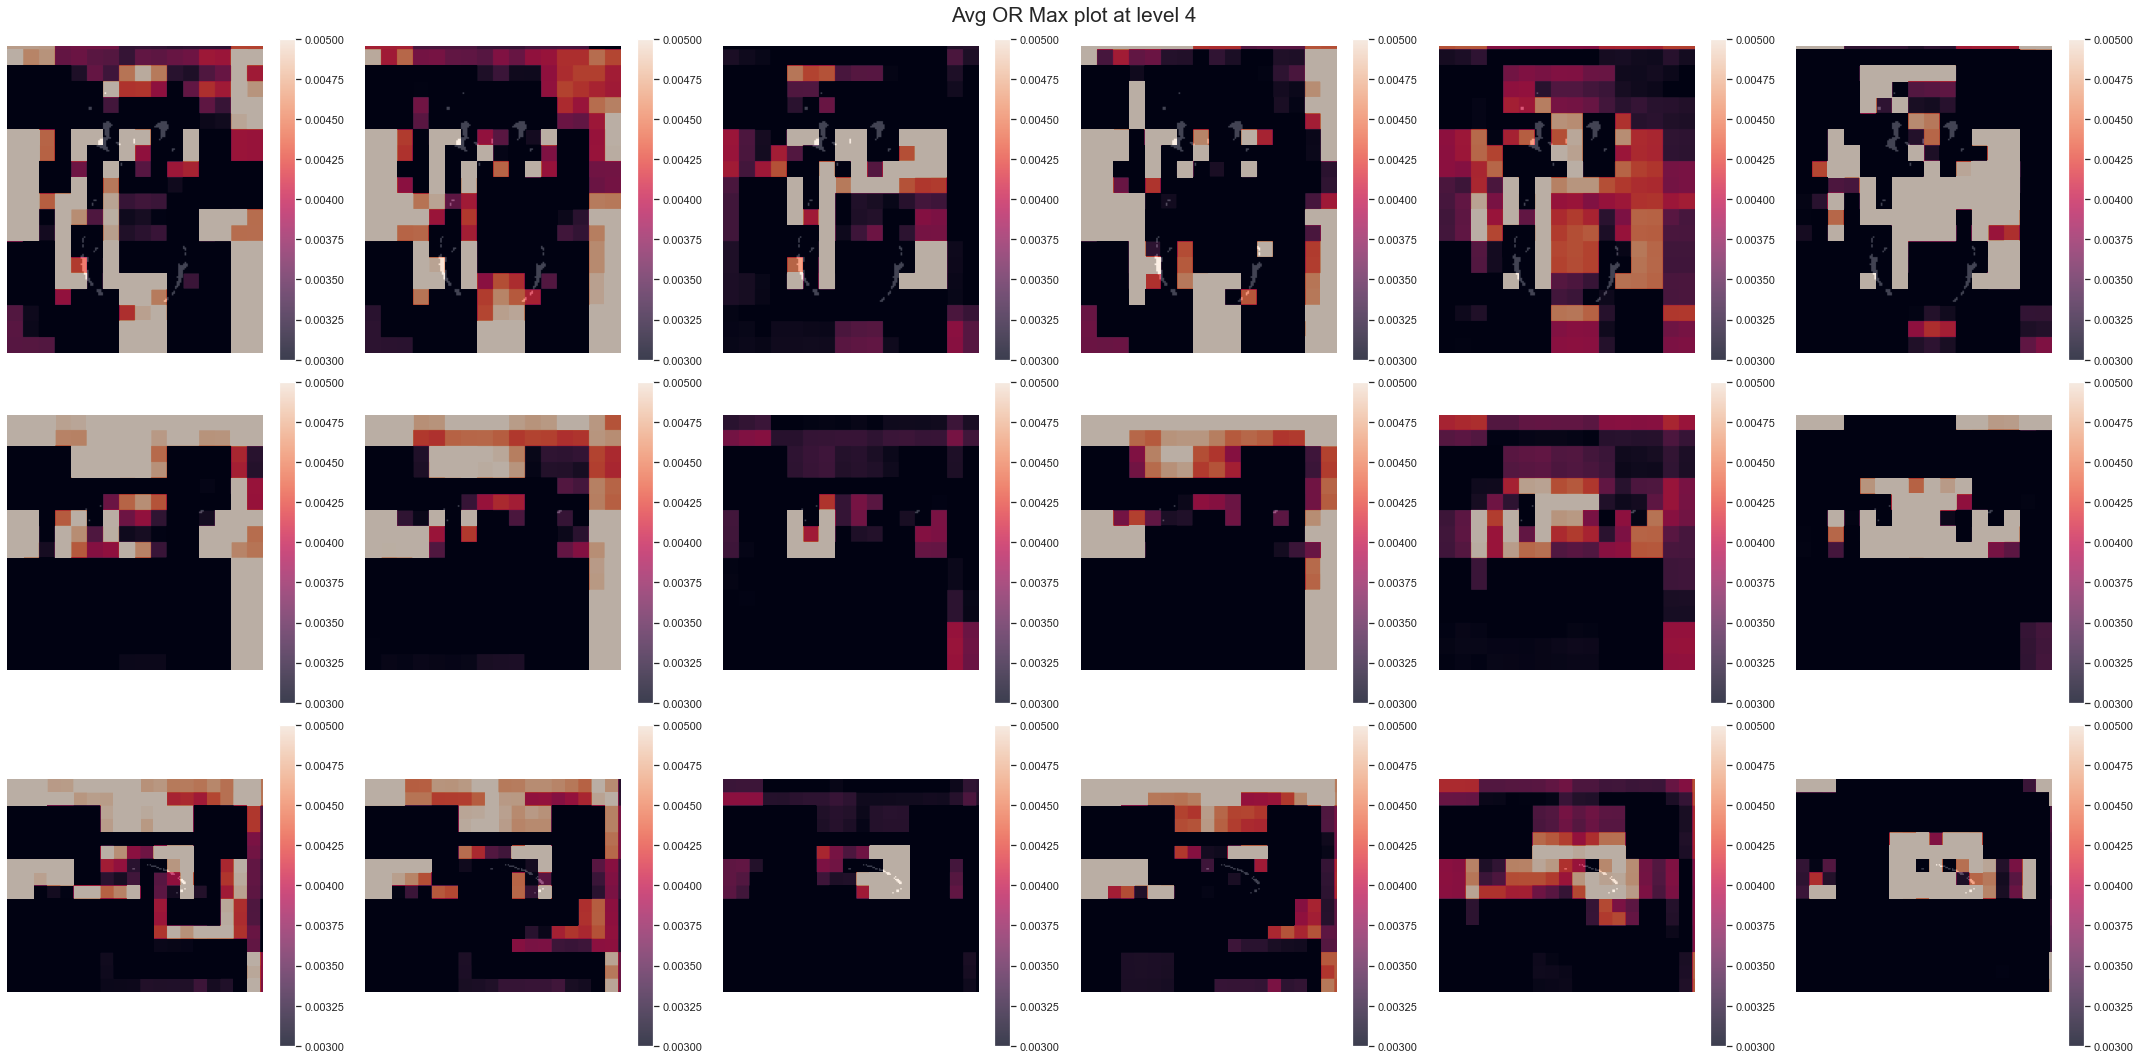

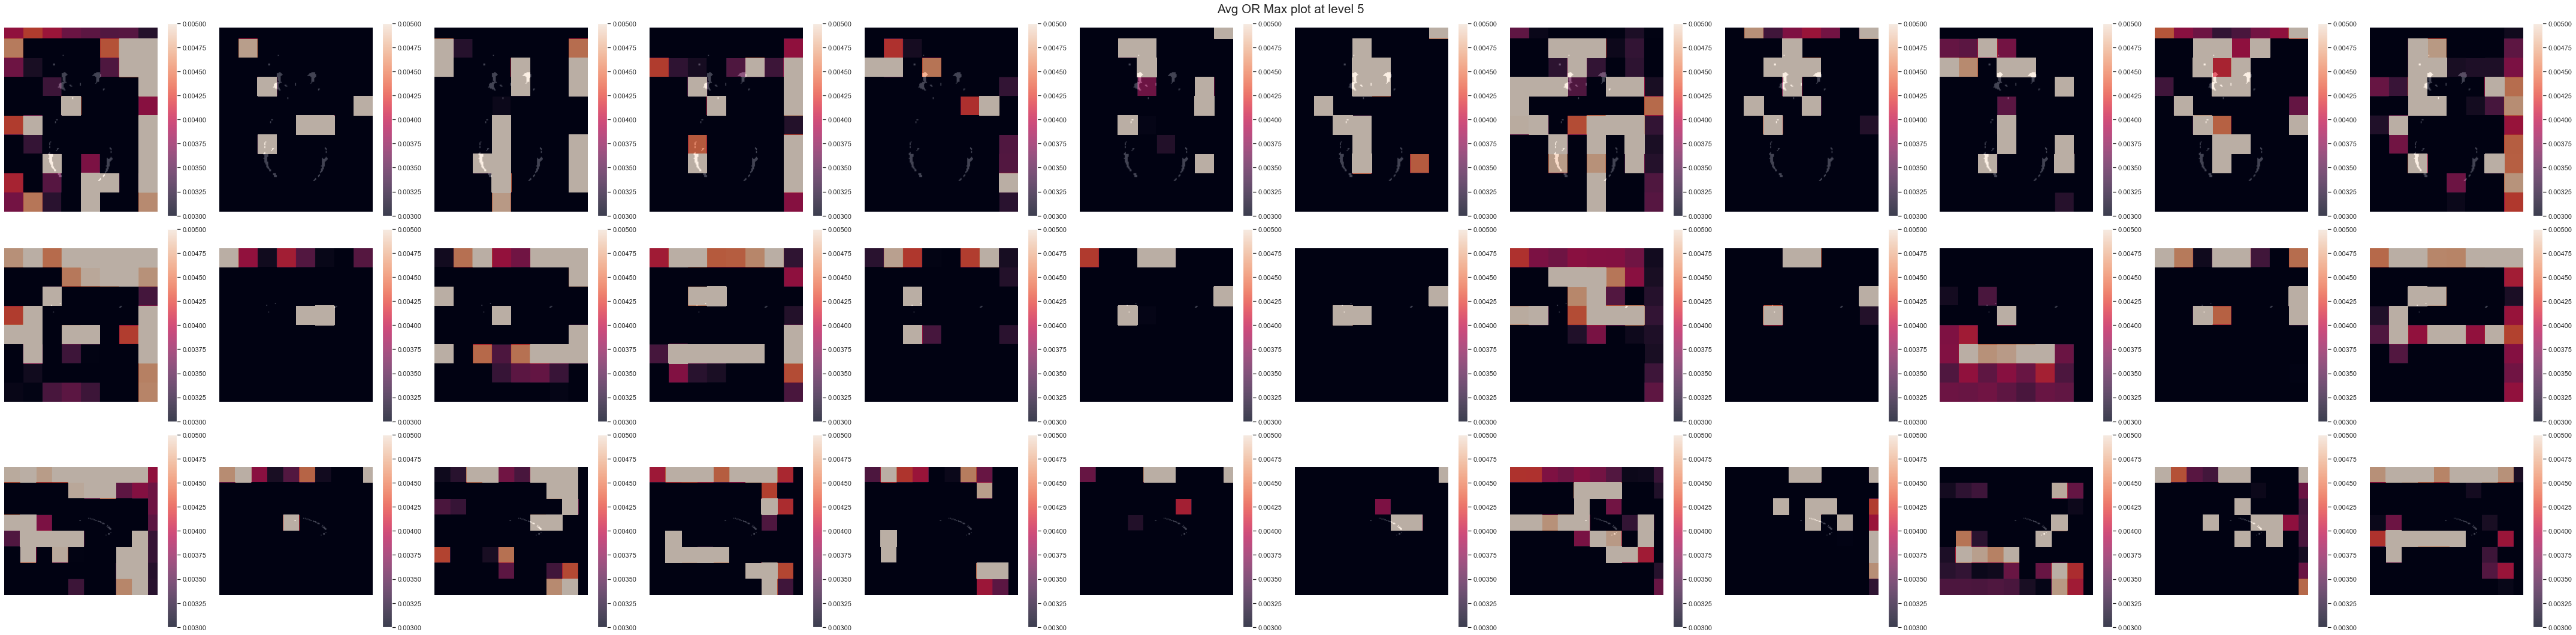

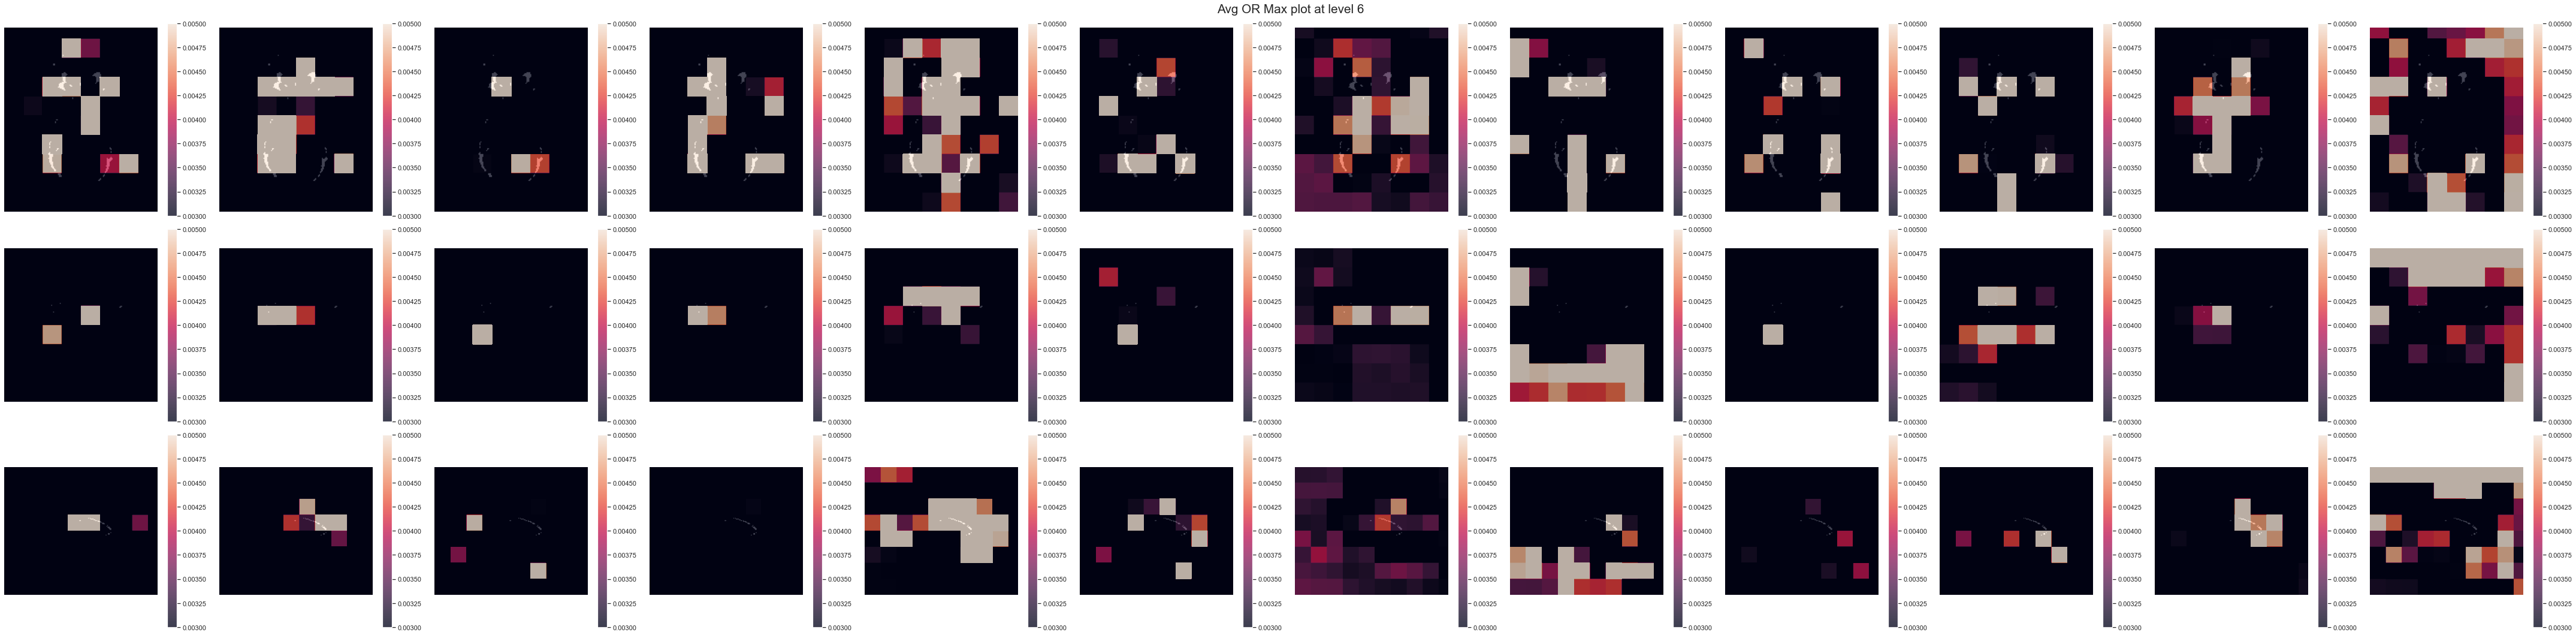

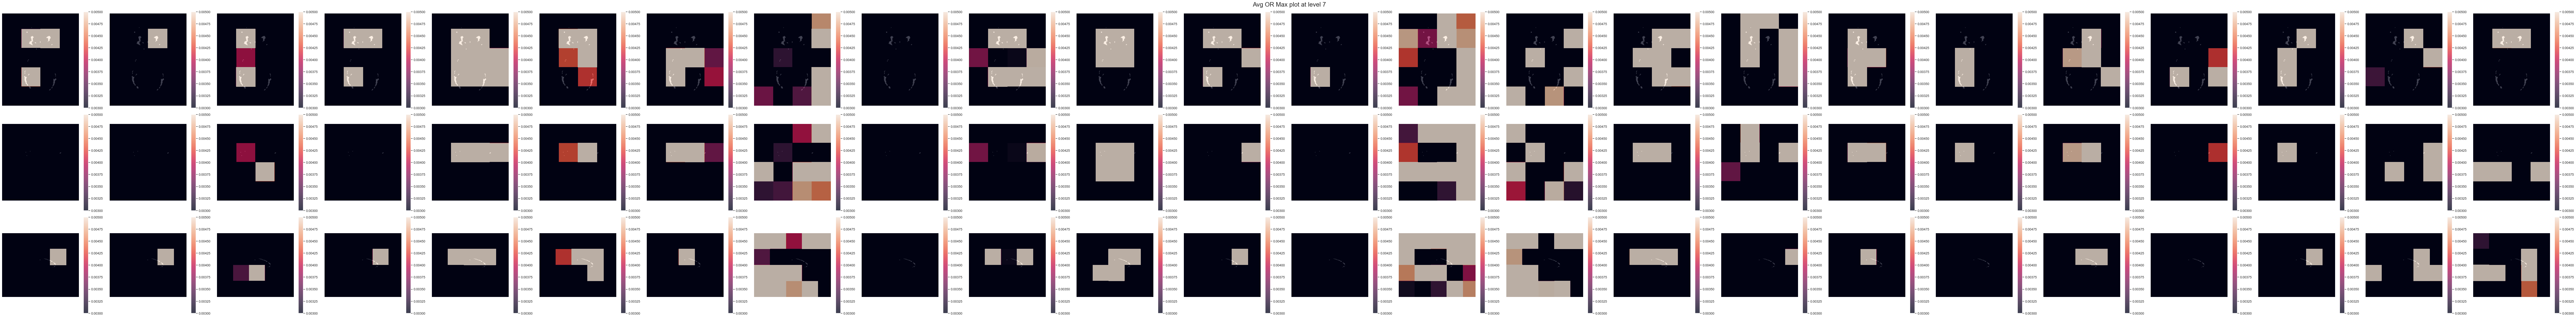

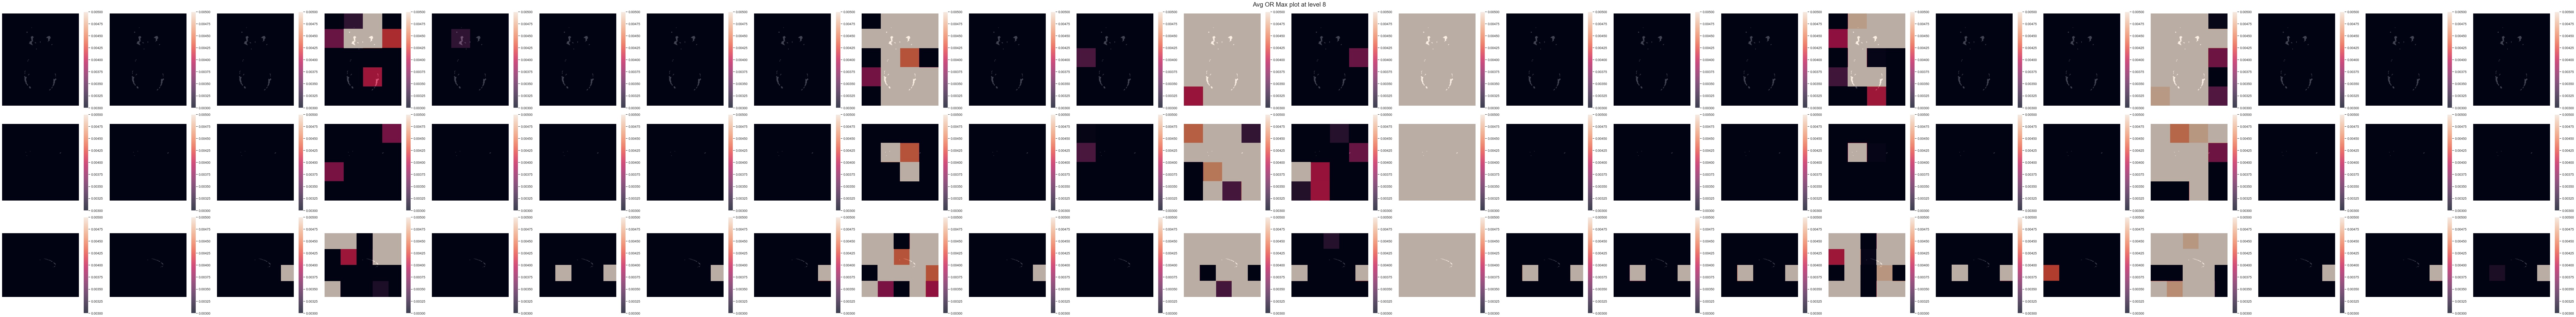

In [43]:
for i in range(0,8):
    plotAttentionHead_Overlay(outUpS, i, cmap=None, vmin=0.003, vmax=0.005)

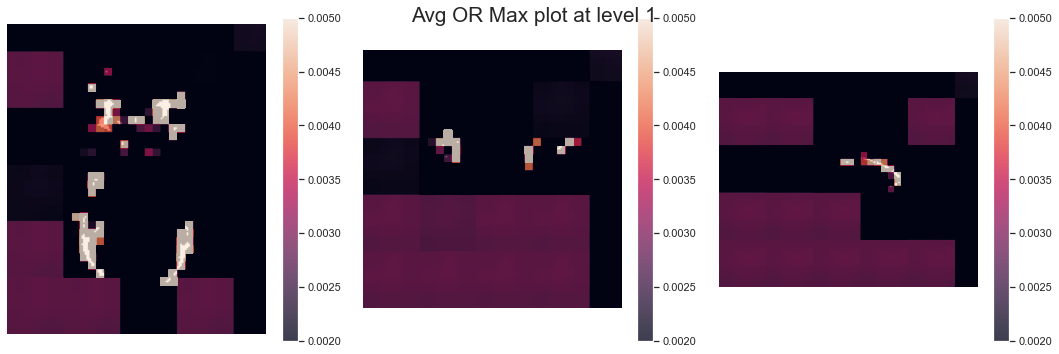

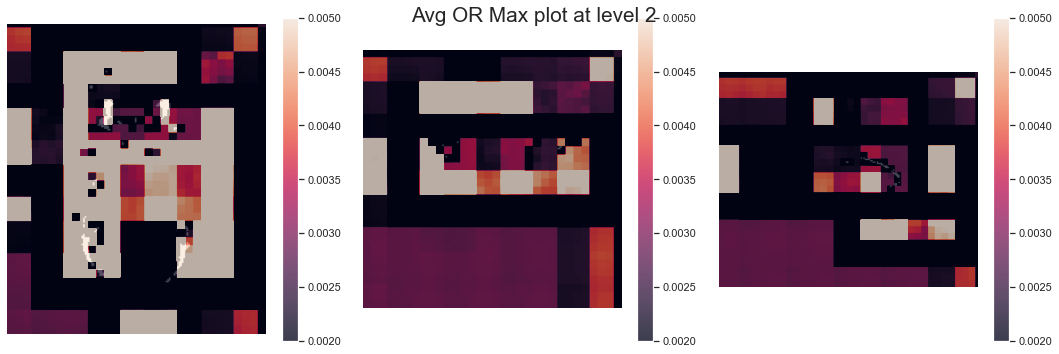

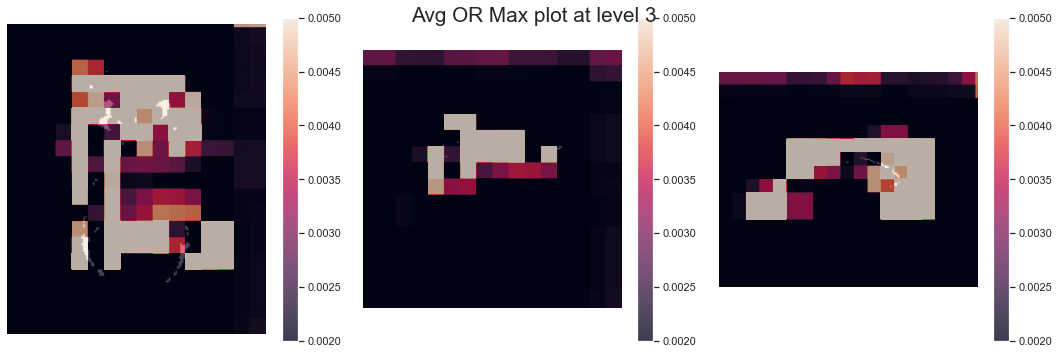

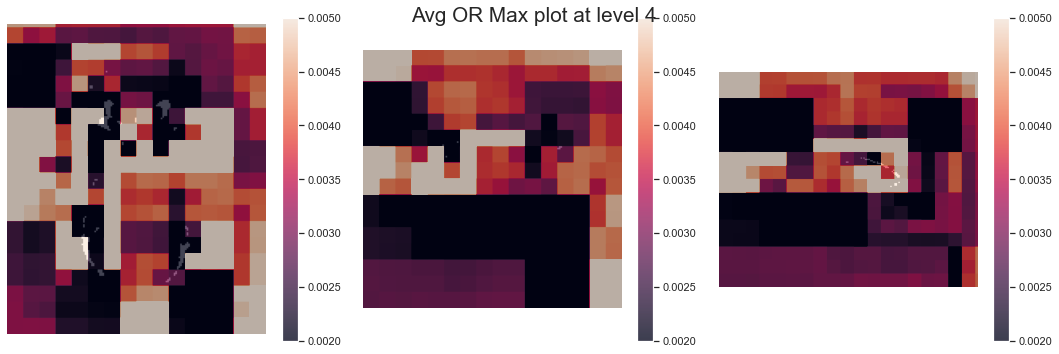

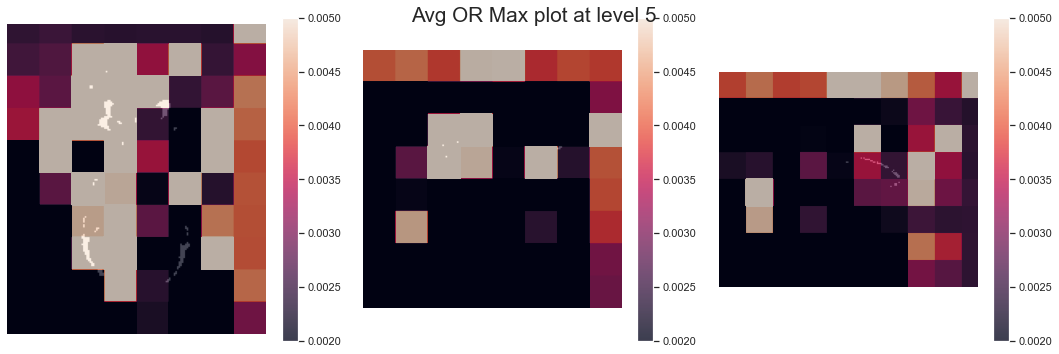

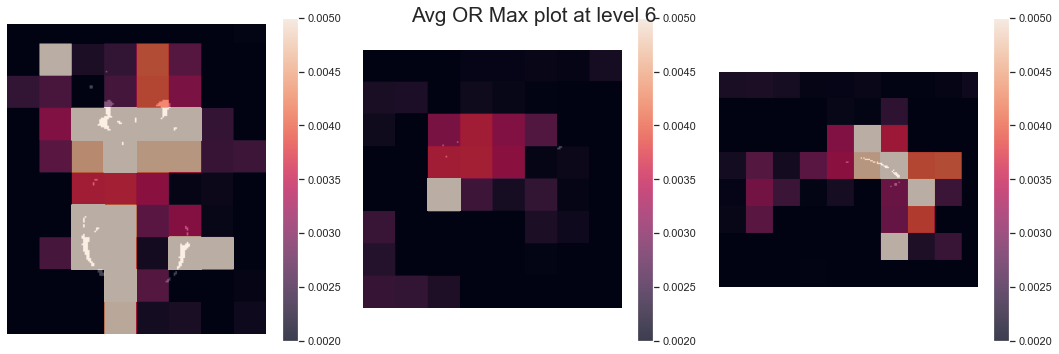

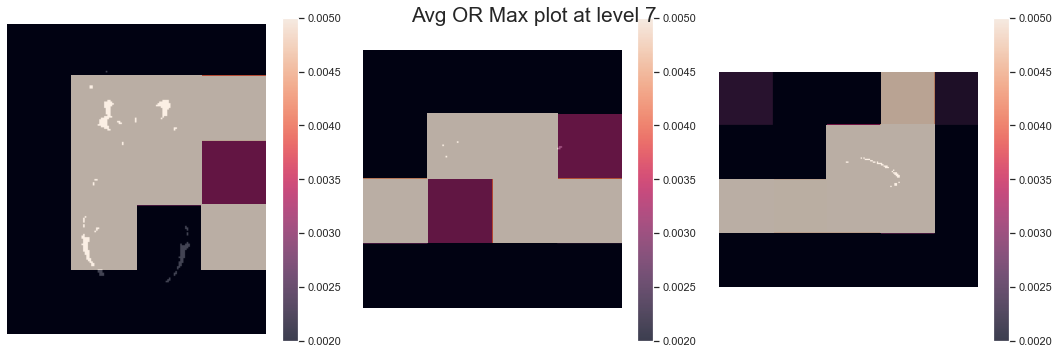

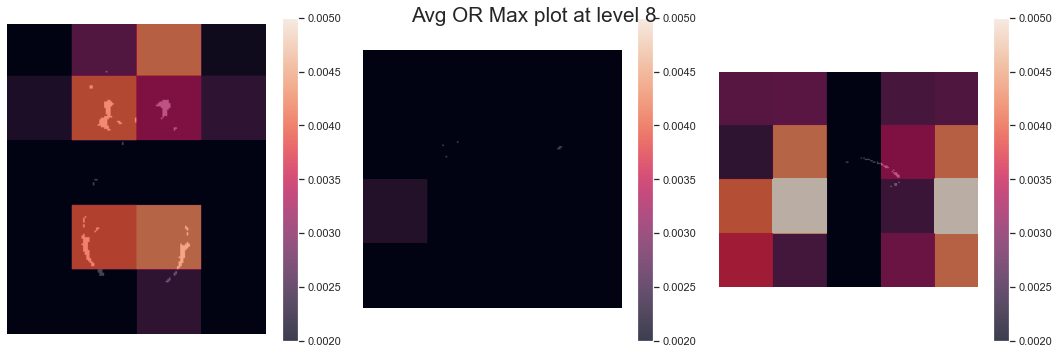

In [44]:
for i in range(0,8):
    plotAttentionHead_Overlay(outUpCropMeanS, i, cmap=None, vmin=0.002, vmax=0.005, minMax=True)

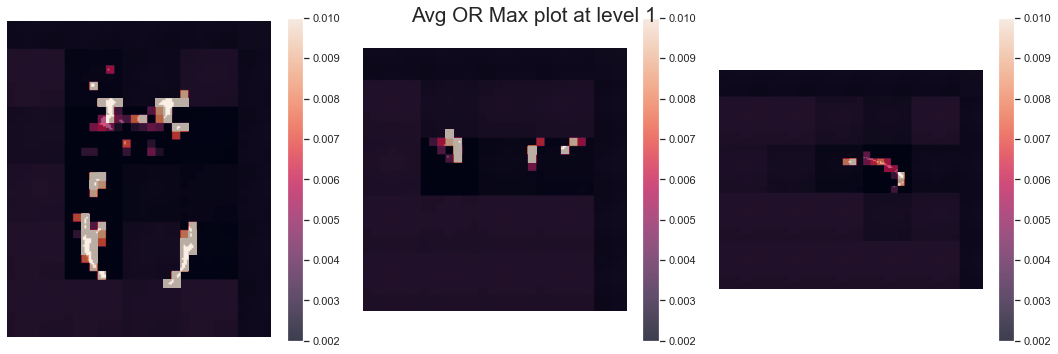

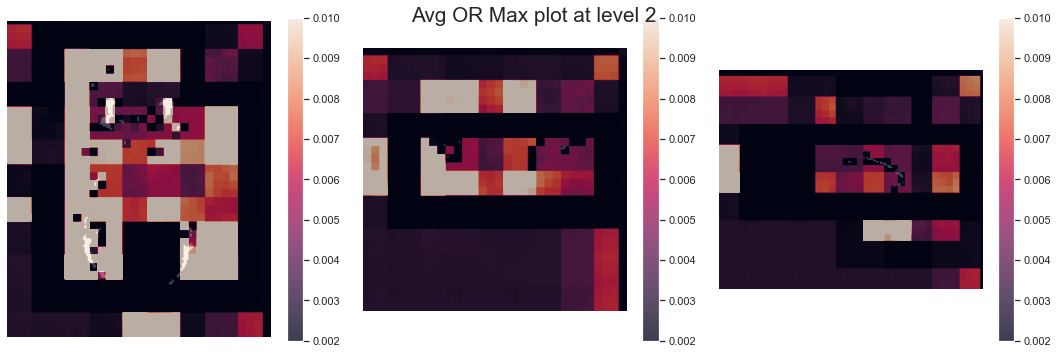

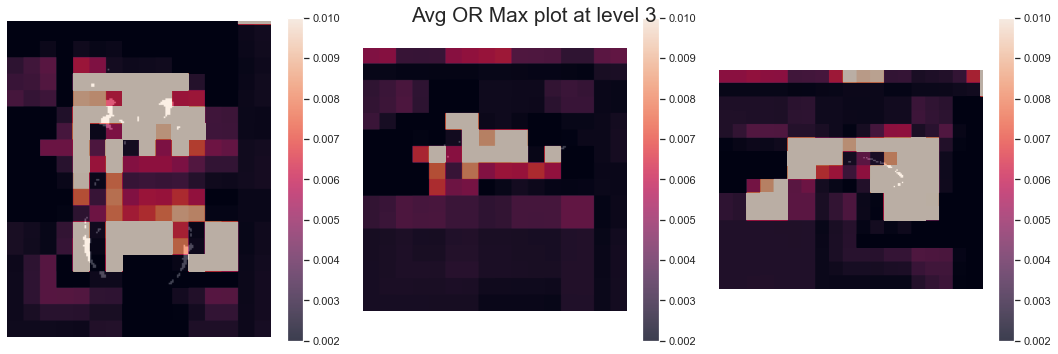

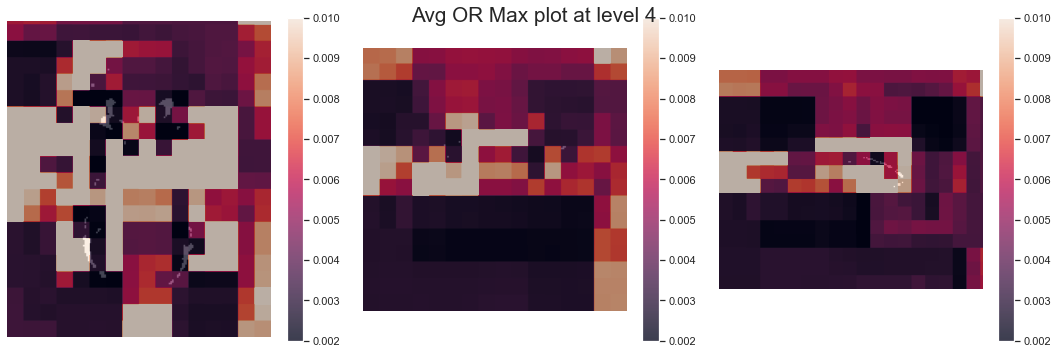

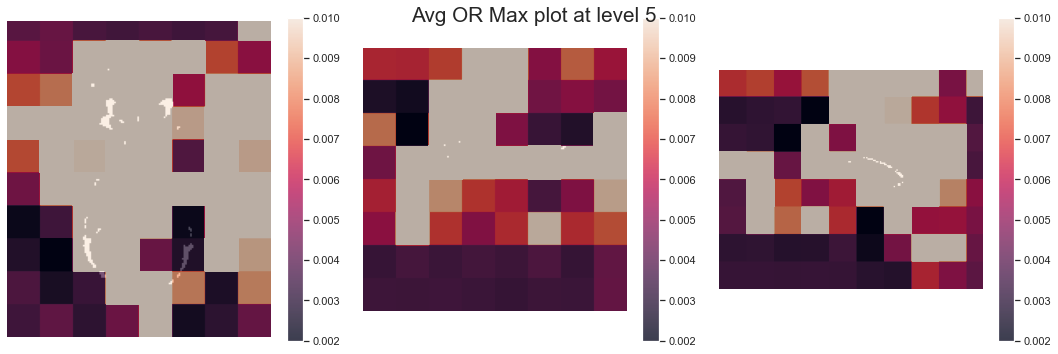

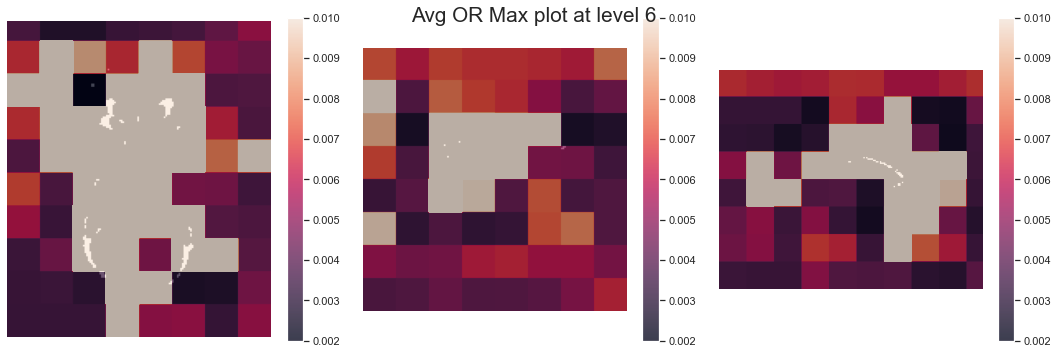

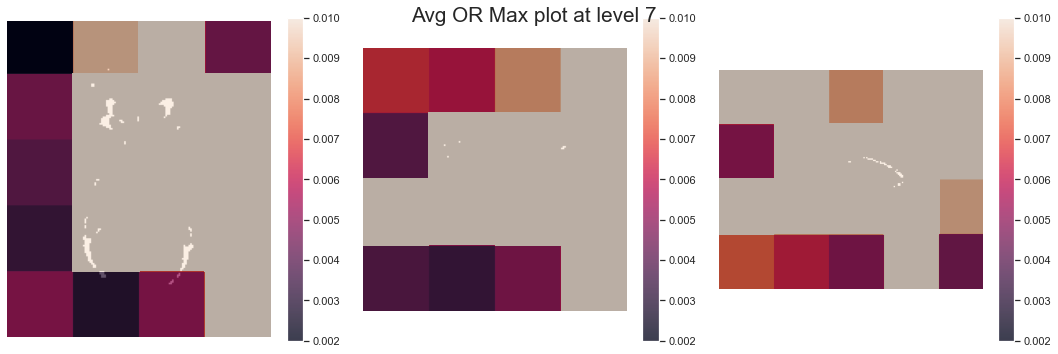

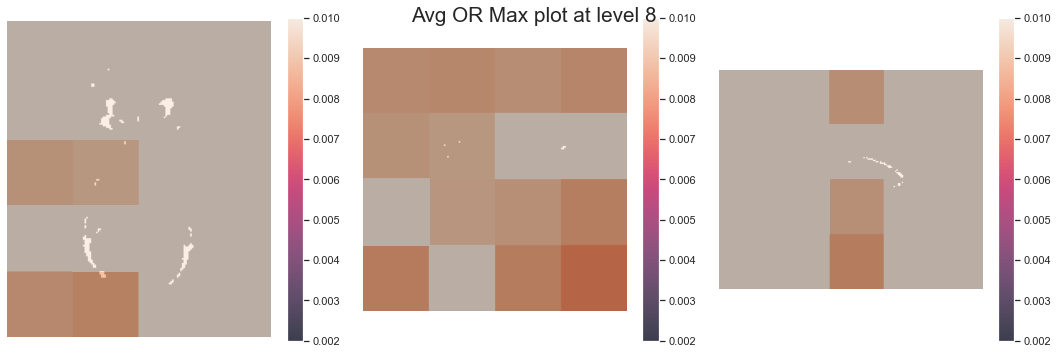

In [45]:
for i in range(0,8):
    plotAttentionHead_Overlay(outUpCropMaxS, i, cmap=None, vmin=0.002, vmax=0.01, minMax=True)